In [93]:
import pandas as pd
import pyarrow.parquet as pq
from plotnine import *
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import numpy as np
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import make_scorer
from sksurv.metrics import concordance_index_censored
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lifelines import CoxPHFitter
from sklearn.metrics import mean_squared_error
from lifelines import WeibullAFTFitter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import brier_score
from scipy.integrate import trapezoid
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_score, recall_score, roc_auc_score
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

# Import Data into df

In [94]:
file_path = "f5_project_data.parquet"
# Read the Parquet file
table = pq.read_table(file_path)

# Convert to a pandas DataFrame if needed
df = table.to_pandas()

# Display the first few rows of the DataFrame
df.head()

,id,calendar_date,time_step,customer_status,contract_end_date,target_label,target_date,x1,x2,x1_cumulative,x2_cumulative,cat1,cat2,cat3
0,00009f6933514b6ec345aa904b6329eb,2021-11-30,1.0,active,2022-11-30,1.0,2023-04-01,2.0,2.0,2.0,2.0,B,D,I
1,00009f6933514b6ec345aa904b6329eb,2021-12-31,2.0,active,2022-11-30,1.0,2023-04-01,2.0,2.0,2.0,2.0,B,D,I
2,00009f6933514b6ec345aa904b6329eb,2022-01-31,3.0,active,2022-11-30,1.0,2023-04-01,2.0,2.0,2.0,2.0,B,D,I
3,00009f6933514b6ec345aa904b6329eb,2022-02-28,4.0,active,2022-11-30,1.0,2023-04-01,2.0,2.0,2.0,2.0,B,D,I
4,00009f6933514b6ec345aa904b6329eb,2022-03-31,5.0,active,2022-11-30,1.0,2023-04-01,2.0,2.0,2.0,2.0,B,D,I


# Contract Renewal Features

In [95]:
# Ensure 'date' is in datetime format
df["calendar_date"] = pd.to_datetime(df["calendar_date"])
df["target_date"] = pd.to_datetime(df["target_date"])
df["contract_end_date"] = pd.to_datetime(df["contract_end_date"])

## remain_contract_month

In [96]:
# remain_contract_month: months left in a contract and ensure it doesn't go below 0
df['remain_contract_month'] = ((df['contract_end_date'] - df['calendar_date']).dt.days / 30).round()
df['remain_contract_month'] = df['remain_contract_month'].clip(lower=0)

## df_changes

extracting date information and grouping by contract_end_date per customer. 

df_changes contains repeats of customer id's but only one contract per row!

In [97]:
# Convert the column to datetime format
df['contract_end_date'] = pd.to_datetime(df['contract_end_date'])

# Extract year, month, and day as separate columns
df['year'] = df['contract_end_date'].dt.year
df['month'] = df['contract_end_date'].dt.month
df['day'] = df['contract_end_date'].dt.day

# Identify rows where any of year, month, or day changes compared to the previous row
df_changes = df[(df['year'].ne(df['year'].shift())) |
                (df['month'].ne(df['month'].shift())) |
                (df['day'].ne(df['day'].shift())) |
                (df['time_step'] == 1)] 

df_changes = df_changes[df_changes['remain_contract_month'] > 0]

In [98]:
# Display the resulting DataFrame with changes
df_changes

,id,calendar_date,time_step,customer_status,contract_end_date,target_label,target_date,x1,x2,x1_cumulative,x2_cumulative,cat1,cat2,cat3,remain_contract_month,year,month,day
0,00009f6933514b6ec345aa904b6329eb,2021-11-30,1.0,active,2022-11-30,1.0,2023-04-01,2.0,2.0,2.0,2.0,B,D,I,12.0,2022,11,30
35,000236e342ff4aef5ea329581124825f,2010-07-31,1.0,active,2011-07-31,1.0,2020-01-01,4.0,2.0,4.0,2.0,D,B,K,12.0,2011,7,31
47,000236e342ff4aef5ea329581124825f,2011-07-31,13.0,active,2012-07-31,1.0,2020-01-01,4.0,2.0,6.0,2.0,D,B,K,12.0,2012,7,31
59,000236e342ff4aef5ea329581124825f,2012-07-31,25.0,active,2014-07-31,1.0,2020-01-01,4.0,2.0,8.0,2.0,D,B,K,24.0,2014,7,31
83,000236e342ff4aef5ea329581124825f,2014-07-31,49.0,active,2015-07-31,1.0,2020-01-01,4.0,2.0,10.0,2.0,D,B,K,12.0,2015,7,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4382895,ffff7a608c0d2acc4281dc6b99027ea7,2008-04-30,4.0,active,2009-04-30,1.0,2014-04-01,2.0,1.0,2.0,1.0,D,A,A,12.0,2009,4,30
4382907,ffff7a608c0d2acc4281dc6b99027ea7,2009-04-30,16.0,active,2010-04-30,1.0,2014-04-01,2.0,1.0,3.0,1.0,D,A,A,12.0,2010,4,30
4382919,ffff7a608c0d2acc4281dc6b99027ea7,2010-04-30,28.0,active,2011-02-28,1.0,2014-04-01,2.0,1.0,4.0,1.0,D,A,A,10.0,2011,2,28
4382929,ffff7a608c0d2acc4281dc6b99027ea7,2011-02-28,38.0,active,2012-02-29,1.0,2014-04-01,2.0,1.0,5.0,1.0,D,A,A,12.0,2012,2,29


In [99]:
df_changes[(df_changes['time_step']==1)&(df_changes['remain_contract_month']==97)]

,id,calendar_date,time_step,customer_status,contract_end_date,target_label,target_date,x1,x2,x1_cumulative,x2_cumulative,cat1,cat2,cat3,remain_contract_month,year,month,day
307419,11e549f0c688a11b8cd020c00add5498,2020-05-31,1.0,active,2028-05-31,0.0,NaT,1.0,1.0,1.0,1.0,B,D,F,97.0,2028,5,31
2085204,79840f5660fb681b448022d9204fd7ec,2021-08-31,1.0,active,2029-08-31,0.0,NaT,6.0,2.0,6.0,2.0,A,A,A,97.0,2029,8,31


In [100]:
df_changes[df_changes['time_step']==1]['remain_contract_month'].describe()

count    34340.000000
mean        16.191672
std         14.586376
min          1.000000
25%         10.000000
50%         12.000000
75%         12.000000
max         97.000000
Name: remain_contract_month, dtype: float64

In [101]:
df_changes[(df_changes['cat1']=='A') & (df_changes['cat2']=='A') & (df_changes['cat3']=='B')& (df_changes['time_step']==1)]['remain_contract_month'].describe()

count    19.000000
mean     21.842105
std      15.345152
min       3.000000
25%       7.000000
50%      23.000000
75%      36.500000
max      41.000000
Name: remain_contract_month, dtype: float64

### calculating total contract count for each customer

In [102]:
total_contract_counts = df_changes.groupby('id').size().reset_index(name='total_contract_count')
total_contract_counts.head()

,id,total_contract_count
0,00009f6933514b6ec345aa904b6329eb,1
1,000236e342ff4aef5ea329581124825f,8
2,0004ec4840a76d1e4be515bc1fe9b29c,3
3,000a6180e6e1c6cac570d9396bc9f7a2,8
4,000ab9309fc049b1b0025e55204b413f,14


### contract length calculations

In [103]:
# Extract the last contract length for each customer
last_contracts = df_changes.groupby('id').last().reset_index()

# Compute contract length statistics, including last contract length
contract_lengths = df_changes.groupby('id')['remain_contract_month'].agg(
    avg_contract_length='mean',
    longest_contract='max',
    shortest_contract='min',
    std_contract_length='std'
).reset_index()

# Replace NaN in standard deviation with 0
contract_lengths['std_contract_length'] = contract_lengths['std_contract_length'].fillna(0)

# Merge the last contract length into contract_lengths
contract_lengths = contract_lengths.merge(
    last_contracts[['id', 'remain_contract_month']], 
    on='id', 
    how='left'
).rename(columns={'remain_contract_month': 'last_contract_length'})

# last_contract_length / avg_contract_length
contract_lengths['last_avg_contract_ratio'] = contract_lengths['last_contract_length'] / contract_lengths['avg_contract_length']

# last_contract_length / longest_contract
# contract_lengths['last_peak_contract_ratio'] = contract_lengths['last_contract_length'] / contract_lengths['longest_contract']

# Display the new DataFrame
contract_lengths.head()

,id,avg_contract_length,longest_contract,shortest_contract,std_contract_length,last_contract_length,last_avg_contract_ratio
0,00009f6933514b6ec345aa904b6329eb,12.000000,12.0,12.0,0.000000,12.0,1.000000
1,000236e342ff4aef5ea329581124825f,13.500000,24.0,12.0,4.242641,12.0,0.888889
2,0004ec4840a76d1e4be515bc1fe9b29c,24.666667,37.0,3.0,18.823744,34.0,1.378378
3,000a6180e6e1c6cac570d9396bc9f7a2,5.250000,12.0,1.0,4.682795,4.0,0.761905
4,000ab9309fc049b1b0025e55204b413f,11.357143,13.0,4.0,2.437121,13.0,1.144654


If the ratio is close to 1:
- The customer's last contract length is consistent with their historical contract lengths, suggesting a stable renewal pattern.
- This could indicate that the customer is not changing their behavior significantly before churning (or they may not churn at all).
- **if its 1 that means that ALL their contracts are the same length (probable that they only had 1 contract)**

If the ratio is lower than 1:
- The last contract is shorter than their average contract length.
- This might indicate that the customer is hesitating to commit, testing shorter-term contracts before churning.
- **they may be shortening their contracts to leave BUT need to establish what ratio is significantly low enough**

If the ratio is greater than 1:
- The last contract is longer than their historical average.
- This could mean the customer has decided to stay longer than usual, perhaps due to a better offer or a change in needs.
- **they may be interested in strengthening their commitments with F5**

## Base data preparation

In [104]:
#churned customer at the last month before target date
churn_last = df[(df['target_label'] == 1) & (df['calendar_date'] == df['target_date']- pd.Timedelta(days=1))]

In [105]:
churn = df[(df['target_label'] == 1) & (df['time_step'] == 1)]
churn = churn[churn['contract_end_date']>churn['calendar_date']]

#churned customer at the first time step of calendar date
churn = churn[['id','calendar_date','target_label','target_date']]
#combined churned customer's the first time step of calendar date with the data at the last month before target date
churn_info = churn_last[['id','time_step','contract_end_date','x1','x2','x1_cumulative','x2_cumulative','cat1','cat2','cat3']]
churn = pd.merge(churn, churn_info, on='id', how='inner')
churn = churn.rename(columns={'time_step':'life'})
churn = churn[(churn['x1'] != 0) & (churn['x2'] != 0)]
churn = churn[churn['contract_end_date']<churn['target_date']]
churn = churn.rename(columns={'calendar_date': 'join_date'})
churn = churn.rename(columns={'x1': 'last_x1'})
churn = churn.rename(columns={'x2': 'last_x2'})
churn['x1/x2'] = churn['x1_cumulative'] / churn['x2_cumulative']
churn['x1_renew_time'] = churn['x1_cumulative'] / churn['last_x1']
churn['x2_renew_time'] = churn['x2_cumulative'] / churn['last_x2']

In [106]:
active_join = df[(df['target_label']==0) & (df['time_step']==1)]
active_join = active_join[['id','calendar_date']]
active_join = active_join.rename(columns={'calendar_date':'join_date'})

In [107]:
active = df[(df['target_label']==0) & (df['calendar_date']=='2024-09-30') & (df['x1'] != 0) & (df['x2'] != 0)]
active = active[(active['customer_status']!='inactive')]
active['life'] = active['time_step']
active = active.drop(columns=['calendar_date','time_step','customer_status'])
active = active.rename(columns={'x1': 'last_x1'})
active = active.rename(columns={'x2': 'last_x2'})
active['x1/x2'] = active['x1_cumulative'] / active['x2_cumulative']
active['x1_renew_time'] = active['x1_cumulative'] / active['last_x1']
active['x2_renew_time'] = active['x2_cumulative'] / active['last_x2']
active = pd.merge(active_join, active, on='id', how='inner')
active = active[active['contract_end_date']<'2040-01-31']

# Creating 'clean' dataset

In [108]:
clean = pd.concat([active,churn])

In [109]:
clean

,id,join_date,contract_end_date,target_label,target_date,last_x1,last_x2,x1_cumulative,x2_cumulative,cat1,cat2,cat3,remain_contract_month,year,month,day,life,x1/x2,x1_renew_time,x2_renew_time
0,000ab9309fc049b1b0025e55204b413f,2013-03-31,2025-03-31,0.0,NaT,4.0,4.0,68.0,8.0,D,B,Other,6.0,2025.0,3.0,31.0,139.0,8.500000,17.000000,2.000000
1,000fdf86eb30848cf9cdf2ecdc6ff063,2022-03-31,2027-02-28,0.0,NaT,4.0,4.0,8.0,6.0,A,B,E,29.0,2027.0,2.0,28.0,31.0,1.333333,2.000000,1.500000
2,0016c95adcdd55040dc65e12da5272d1,2011-10-31,2025-07-31,0.0,NaT,274.0,74.0,364.0,79.0,A,B,B,10.0,2025.0,7.0,31.0,156.0,4.607595,1.328467,1.067568
3,00171e9f7615c2a107e3f279bb278240,2012-09-30,2026-08-31,0.0,NaT,12.0,6.0,79.0,15.0,A,B,B,23.0,2026.0,8.0,31.0,145.0,5.266667,6.583333,2.500000
4,0018a2948dc42c760f015e247b697629,2017-09-30,2025-03-31,0.0,NaT,4.0,4.0,37.0,4.0,D,B,B,6.0,2025.0,3.0,31.0,85.0,9.250000,9.250000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14858,fff0b0b60f40d28c4ceada7bd3f40661,2009-06-30,2020-12-31,1.0,2021-04-01,4.0,4.0,38.0,4.0,D,A,D,NaN,NaN,NaN,NaN,142.0,9.500000,9.500000,1.000000
14859,fff3238a5321f59329273c1057aa3f80,2017-03-31,2018-06-30,1.0,2018-10-01,2.0,2.0,4.0,2.0,A,A,D,NaN,NaN,NaN,NaN,19.0,2.000000,2.000000,1.000000
14860,fff817a566d13c9356513d7b89663c5c,2015-03-31,2021-03-31,1.0,2021-07-01,1.0,1.0,11.0,1.0,A,B,Other,NaN,NaN,NaN,NaN,76.0,11.000000,11.000000,1.000000
14861,fffd2924ba0addf466b784ce149e7643,2016-03-31,2023-06-30,1.0,2023-10-01,6.0,3.0,36.0,3.0,B,C,B,NaN,NaN,NaN,NaN,91.0,12.000000,6.000000,1.000000


# Creating agg_stats for x1 & x2

In [110]:
# Filter the DataFrame for rows where calendar_date is prior to target_date or target_label == 0
filtered_df = df[(df['calendar_date'] < df['target_date']) | (df['target_label'] == 0)]

# Define the columns for which you want to calculate statistics
columns_to_aggregate = ['x1', 'x2', 'x1_cumulative', 'x2_cumulative']

# Group by 'id' and calculate the mean, median, min, max, and std for the selected columns
agg_stats = filtered_df.groupby('id')[columns_to_aggregate].agg(['mean', 'median', 'min', 'max', 'std'])

# Flatten the multi-level column index
agg_stats.columns = ['_'.join(col) for col in agg_stats.columns]

# Reset the index to convert the result back into a DataFrame
agg_stats = agg_stats.reset_index()

# Display the aggregated statistics
print(agg_stats)

agg_stats.describe()


                                     id  ...  x2_cumulative_std
0      00009f6933514b6ec345aa904b6329eb  ...           0.000000
1      000236e342ff4aef5ea329581124825f  ...           0.000000
2      0004ec4840a76d1e4be515bc1fe9b29c  ...           0.000000
3      000a6180e6e1c6cac570d9396bc9f7a2  ...           0.000000
4      000ab9309fc049b1b0025e55204b413f  ...           1.979564
...                                 ...  ...                ...
36763  fff817a566d13c9356513d7b89663c5c  ...           0.000000
36764  fffd218d9e609f49e52389e2c446cbf3  ...          12.819652
36765  fffd2924ba0addf466b784ce149e7643  ...           0.000000
36766  fffe8bac7dac67aa73308d0d2b73dbeb  ...           0.000000
36767  ffff7a608c0d2acc4281dc6b99027ea7  ...           0.000000

[36768 rows x 21 columns]
                                     id  ...  x2_cumulative_std
0      00009f6933514b6ec345aa904b6329eb  ...           0.000000
1      000236e342ff4aef5ea329581124825f  ...           0.000000
2      0004ec

,x1_mean,x1_median,x1_min,x1_max,x1_std,x2_mean,x2_median,x2_min,x2_max,x2_std,x1_cumulative_mean,x1_cumulative_median,x1_cumulative_min,x1_cumulative_max,x1_cumulative_std,x2_cumulative_mean,x2_cumulative_median,x2_cumulative_min,x2_cumulative_max,x2_cumulative_std
count,36768.000000,36768.000000,36768.000000,36768.000000,36717.000000,36768.000000,36768.000000,36768.000000,36768.000000,36717.000000,36768.000000,36768.000000,36768.000000,36768.000000,36717.000000,36768.000000,36768.000000,36768.000000,36768.000000,36717.000000
mean,11.225640,10.075269,2.687663,27.554993,6.580980,6.079700,5.960700,1.943919,10.779020,2.693137,41.311964,37.964602,4.697781,87.537750,27.268401,8.445501,8.574712,2.417047,13.818728,3.757208
std,52.203568,44.208984,3.762806,165.034740,45.216770,28.564312,27.537454,2.004539,64.484565,20.809208,249.297782,220.611524,4.824541,609.386951,205.153883,50.120048,55.417731,2.232160,90.678270,30.238480
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.728685,2.000000,1.000000,4.000000,0.955089,2.000000,2.000000,1.000000,2.000000,0.000000,6.000000,6.000000,2.000000,8.000000,1.258786,2.000000,2.000000,1.000000,2.000000,0.000000
50%,4.636364,4.000000,2.000000,8.000000,1.872055,2.403786,2.000000,2.000000,4.000000,0.529785,12.069265,12.000000,4.000000,20.000000,4.958903,3.000000,3.000000,2.000000,4.000000,0.457496
75%,8.837282,8.000000,4.000000,19.000000,4.221345,4.785714,4.000000,2.000000,8.000000,1.712410,28.626497,28.000000,5.000000,53.000000,15.302011,6.134876,6.000000,2.000000,9.000000,2.046330
max,4427.452736,4644.000000,173.000000,13085.000000,4773.714349,2860.044776,3194.000000,90.000000,5762.000000,2175.191329,25361.293532,20196.000000,186.000000,61176.000000,20087.233100,4755.975124,5796.000000,90.000000,9319.000000,3062.746872


# Merging datasets INTO clean

agg_stats, contract_lengths, total_contract_counts

In [111]:
clean = clean.merge(agg_stats, on='id', how='left')
clean = clean.merge(contract_lengths, on='id', how='left')
clean = clean.merge(total_contract_counts, on='id', how='left')

In [112]:
clean['x1_std'] = clean['x1_std'].fillna(0)
clean['x2_std'] = clean['x2_std'].fillna(0)
clean['x1_cumulative_std'] = clean['x1_cumulative_std'].fillna(0)
clean['x2_cumulative_std'] = clean['x2_cumulative_std'].fillna(0)

# Create dataset at certain time point

In [113]:
def create_df(df, time_point, future_point, id_list):
    """
    Process the dataframe based on specified conditions and return a new dataframe.
    
    Args:
        df (pd.DataFrame): The input dataframe.
        time_point (int/float): The reference time point.
        future_point (int/float): The future time point to evaluate customer status.
        id_list (list): List of IDs to filter.
    
    Returns:
        pd.DataFrame: Processed dataframe with aggregated statistics.
    """
    # Filter dataframe based on id_list
    if isinstance(id_list, pd.DataFrame):
        id_list = id_list['id'].tolist()  # Convert column to a list
    filtered_df = df[df['id'].isin(id_list)]

    # Exclude IDs where customer_status is 'inactive' at time_step == time_point
    active_at_time_point = filtered_df[(filtered_df['time_step'] == time_point) & (filtered_df['customer_status'] != 'inactive')]['id'].unique()
    filtered_df = filtered_df[filtered_df['id'].isin(active_at_time_point)]

    # Create target_label based on future customer status
    future_status = filtered_df[filtered_df['time_step'] == future_point]
    valid_future_ids = future_status['id'].unique()
    
    # Remove IDs that do not have future_point data
    filtered_df = filtered_df[filtered_df['id'].isin(valid_future_ids)]
    
    target_map = dict(zip(future_status['id'], (future_status['customer_status'] == 'inactive').astype(int)))
    filtered_df['target_label'] = filtered_df['id'].map(target_map).fillna(0).astype(int)
    
    # Filter rows where time_step <= time_point
    filtered_df = filtered_df[filtered_df['time_step'] <= time_point]
    
    # Define columns for aggregation
    columns_to_aggregate = ['x1', 'x2', 'x1_cumulative', 'x2_cumulative']
    
    # Group by 'id' and compute statistical aggregations
    agg_stats = filtered_df.groupby('id')[columns_to_aggregate].agg(['mean', 'median', 'min', 'max', 'std'])
    
    # Flatten multi-level columns
    agg_stats.columns = ['_'.join(col) for col in agg_stats.columns]
    
    # Reset index
    agg_stats = agg_stats.reset_index()

    filtered_df['remain_contract_month'] = ((filtered_df['contract_end_date'] - filtered_df['calendar_date']).dt.days / 30).round()
    filtered_df['remain_contract_month'] = filtered_df['remain_contract_month'].clip(lower=0)

    # Identify rows where any of year, month, or day changes compared to the previous row
    df_changes = filtered_df[(filtered_df['year'].ne(filtered_df['year'].shift())) |
                (filtered_df['month'].ne(filtered_df['month'].shift())) |
                (filtered_df['day'].ne(filtered_df['day'].shift())) |
                (filtered_df['time_step'] == 1)] 
    df_changes = df_changes[df_changes['remain_contract_month'] > 0]

    # Extract the last contract length for each customer
    last_contracts = df_changes.groupby('id').last().reset_index()

    # Compute contract length statistics, replacing NaN std with 0
    contract_lengths = df_changes.groupby('id')['remain_contract_month'].agg(
    avg_contract_length='mean',
    longest_contract='max',
    shortest_contract='min',
    std_contract_length='std'
    ).reset_index()

    # Replace NaN in standard deviation with 0
    contract_lengths['std_contract_length'] = contract_lengths['std_contract_length'].fillna(0)

    # Merge the last contract length into contract_lengths
    contract_lengths = contract_lengths.merge(
        last_contracts[['id', 'remain_contract_month']], 
        on='id', 
        how='left'
    ).rename(columns={'remain_contract_month': 'last_contract_length'})

    # last_contract_length / avg_contract_length
    contract_lengths['last_avg_contract_ratio'] = contract_lengths['last_contract_length'] / contract_lengths['avg_contract_length']


    total_contract_counts = df_changes.groupby('id').size().reset_index(name='total_contract_count')


    # Take only the rows where `time_step == time_point` for feature engineering
    filtered_df = filtered_df[filtered_df['time_step'] == time_point]
    
    # Rename columns
    filtered_df = filtered_df.rename(columns={'x1': 'last_x1', 'x2': 'last_x2'})

    # Rename columns
    filtered_df = filtered_df.rename(columns={'x1': 'last_x1', 'x2': 'last_x2'})
    
    # Compute derived features
    filtered_df['x1/x2'] = filtered_df['x1_cumulative'] / filtered_df['x2_cumulative']
    filtered_df['x1_renew_time'] = filtered_df['x1_cumulative'] / filtered_df['last_x1']
    filtered_df['x2_renew_time'] = filtered_df['x2_cumulative'] / filtered_df['last_x2']

    # Merge with agg_stats
    filtered_df = filtered_df.merge(agg_stats, on='id', how='left')
    filtered_df = filtered_df.merge(contract_lengths, on='id', how='left')
    filtered_df = filtered_df.merge(total_contract_counts, on='id', how='left')


    return filtered_df


# Clustering

## Create datasets for clustering (only cat1 and cat2)

In [114]:
clean['Category_Combo2'] = clean['cat1'] + '-' + clean['cat2']

In [115]:
cluster_id = clean[~clean['Category_Combo2'].isin(['N/A-A', 'D-N/A', 'C-N/A'])]['id'].to_list()

In [116]:
cluster_12 = create_df(df, 12, 12, cluster_id)
cluster_12 = cluster_12.merge(clean[['id', 'Category_Combo2']], on='id', how='left')

cluster_24 = create_df(df, 24, 24, cluster_id)
cluster_24 = cluster_24.merge(clean[['id', 'Category_Combo2']], on='id', how='left')

cluster_36 = create_df(df, 36, 36, cluster_id)
cluster_36 = cluster_36.merge(clean[['id', 'Category_Combo2']], on='id', how='left') 


In [117]:
cluster_18 = create_df(df, 18, 18, cluster_id)
cluster_18 = cluster_18.merge(clean[['id', 'Category_Combo2']], on='id', how='left') 

cluster_30 = create_df(df, 30, 30, cluster_id)
cluster_30 = cluster_30.merge(clean[['id', 'Category_Combo2']], on='id', how='left') 

cluster_48 = create_df(df, 48, 48, cluster_id)
cluster_48 = cluster_48.merge(clean[['id', 'Category_Combo2']], on='id', how='left') 

In [118]:
cluster_12_median = cluster_12.groupby('Category_Combo2')[['last_x1', 'last_x2', 'x1_cumulative', 'x2_cumulative','x1/x2', 'x1_renew_time', 'x2_renew_time', 'x1_mean', 'x1_median',
       'x1_min', 'x1_max', 'x1_std', 'x2_mean', 'x2_median', 'x2_min',
       'x2_max', 'x2_std', 'x1_cumulative_mean', 'x1_cumulative_median',
       'x1_cumulative_min', 'x1_cumulative_max', 'x1_cumulative_std',
       'x2_cumulative_mean', 'x2_cumulative_median', 'x2_cumulative_min',
       'x2_cumulative_max', 'x2_cumulative_std', 'avg_contract_length',
       'longest_contract', 'shortest_contract', 'std_contract_length',
       'last_contract_length', 'last_avg_contract_ratio',
       'total_contract_count']].median().reset_index()

cluster_24_median = cluster_24.groupby('Category_Combo2')[['last_x1', 'last_x2', 'x1_cumulative', 'x2_cumulative','x1/x2', 'x1_renew_time', 'x2_renew_time', 'x1_mean', 'x1_median',
       'x1_min', 'x1_max', 'x1_std', 'x2_mean', 'x2_median', 'x2_min',
       'x2_max', 'x2_std', 'x1_cumulative_mean', 'x1_cumulative_median',
       'x1_cumulative_min', 'x1_cumulative_max', 'x1_cumulative_std',
       'x2_cumulative_mean', 'x2_cumulative_median', 'x2_cumulative_min',
       'x2_cumulative_max', 'x2_cumulative_std', 'avg_contract_length',
       'longest_contract', 'shortest_contract', 'std_contract_length',
       'last_contract_length', 'last_avg_contract_ratio',
       'total_contract_count']].median().reset_index()

cluster_36_median = cluster_36.groupby('Category_Combo2')[['last_x1', 'last_x2', 'x1_cumulative', 'x2_cumulative','x1/x2', 'x1_renew_time', 'x2_renew_time', 'x1_mean', 'x1_median',
       'x1_min', 'x1_max', 'x1_std', 'x2_mean', 'x2_median', 'x2_min',
       'x2_max', 'x2_std', 'x1_cumulative_mean', 'x1_cumulative_median',
       'x1_cumulative_min', 'x1_cumulative_max', 'x1_cumulative_std',
       'x2_cumulative_mean', 'x2_cumulative_median', 'x2_cumulative_min',
       'x2_cumulative_max', 'x2_cumulative_std', 'avg_contract_length',
       'longest_contract', 'shortest_contract', 'std_contract_length',
       'last_contract_length', 'last_avg_contract_ratio',
       'total_contract_count']].median().reset_index()


In [119]:
cluster_18_median = cluster_18.groupby('Category_Combo2')[['last_x1', 'last_x2', 'x1_cumulative', 'x2_cumulative','x1/x2', 'x1_renew_time', 'x2_renew_time', 'x1_mean', 'x1_median',
       'x1_min', 'x1_max', 'x1_std', 'x2_mean', 'x2_median', 'x2_min',
       'x2_max', 'x2_std', 'x1_cumulative_mean', 'x1_cumulative_median',
       'x1_cumulative_min', 'x1_cumulative_max', 'x1_cumulative_std',
       'x2_cumulative_mean', 'x2_cumulative_median', 'x2_cumulative_min',
       'x2_cumulative_max', 'x2_cumulative_std', 'avg_contract_length',
       'longest_contract', 'shortest_contract', 'std_contract_length',
       'last_contract_length', 'last_avg_contract_ratio',
       'total_contract_count']].median().reset_index()

cluster_30_median = cluster_30.groupby('Category_Combo2')[['last_x1', 'last_x2', 'x1_cumulative', 'x2_cumulative','x1/x2', 'x1_renew_time', 'x2_renew_time', 'x1_mean', 'x1_median',
       'x1_min', 'x1_max', 'x1_std', 'x2_mean', 'x2_median', 'x2_min',
       'x2_max', 'x2_std', 'x1_cumulative_mean', 'x1_cumulative_median',
       'x1_cumulative_min', 'x1_cumulative_max', 'x1_cumulative_std',
       'x2_cumulative_mean', 'x2_cumulative_median', 'x2_cumulative_min',
       'x2_cumulative_max', 'x2_cumulative_std', 'avg_contract_length',
       'longest_contract', 'shortest_contract', 'std_contract_length',
       'last_contract_length', 'last_avg_contract_ratio',
       'total_contract_count']].median().reset_index()

cluster_48_median = cluster_48.groupby('Category_Combo2')[['last_x1', 'last_x2', 'x1_cumulative', 'x2_cumulative','x1/x2', 'x1_renew_time', 'x2_renew_time', 'x1_mean', 'x1_median',
       'x1_min', 'x1_max', 'x1_std', 'x2_mean', 'x2_median', 'x2_min',
       'x2_max', 'x2_std', 'x1_cumulative_mean', 'x1_cumulative_median',
       'x1_cumulative_min', 'x1_cumulative_max', 'x1_cumulative_std',
       'x2_cumulative_mean', 'x2_cumulative_median', 'x2_cumulative_min',
       'x2_cumulative_max', 'x2_cumulative_std', 'avg_contract_length',
       'longest_contract', 'shortest_contract', 'std_contract_length',
       'last_contract_length', 'last_avg_contract_ratio',
       'total_contract_count']].median().reset_index()


In [120]:
# mean of the median
cluster_median_all = pd.concat([cluster_12_median, cluster_24_median, cluster_36_median,cluster_18_median, cluster_30_median, cluster_48_median], ignore_index=True)
cluster_average_all = cluster_median_all.groupby('Category_Combo2')[['last_x1', 'last_x2', 'x1_cumulative', 'x2_cumulative','x1/x2',
        'x1_renew_time', 'x2_renew_time', 'x1_mean', 'x1_median',
       'x1_min', 'x1_max', 'x1_std', 'x2_mean', 'x2_median', 'x2_min',
       'x2_max', 'x2_std', 'x1_cumulative_mean', 'x1_cumulative_median',
       'x1_cumulative_min', 'x1_cumulative_max', 'x1_cumulative_std',
       'x2_cumulative_mean', 'x2_cumulative_median', 'x2_cumulative_min',
       'x2_cumulative_max', 'x2_cumulative_std', 'avg_contract_length',
       'longest_contract', 'shortest_contract', 'std_contract_length',
       'last_contract_length', 'last_avg_contract_ratio',
       'total_contract_count']].mean().reset_index()

cluster_average_all.head()

,Category_Combo2,last_x1,last_x2,x1_cumulative,x2_cumulative,x1/x2,x1_renew_time,x2_renew_time,x1_mean,x1_median,x1_min,x1_max,x1_std,x2_mean,x2_median,x2_min,x2_max,x2_std,x1_cumulative_mean,x1_cumulative_median,x1_cumulative_min,x1_cumulative_max,x1_cumulative_std,x2_cumulative_mean,x2_cumulative_median,x2_cumulative_min,x2_cumulative_max,x2_cumulative_std,avg_contract_length,longest_contract,shortest_contract,std_contract_length,last_contract_length,last_avg_contract_ratio,total_contract_count
0,A-A,3.666667,2.000000,7.166667,2.333333,2.875000,2.024242,1.0,3.688889,3.833333,2.000000,5.833333,1.100729,2.098958,2.000000,2.0,2.166667,0.080554,5.610185,5.500000,4.00,7.166667,1.009862,2.128472,2.166667,2.0,2.333333,0.067314,22.658333,36.666667,11.833333,2.914818,34.000000,1.009247,2.333333
1,A-B,4.333333,2.666667,10.333333,3.000000,3.000000,2.000000,1.0,4.617361,4.000000,2.166667,7.333333,1.468301,2.415741,2.166667,2.0,3.000000,0.183522,7.350231,7.166667,4.00,10.333333,1.890324,2.539815,2.333333,2.0,3.000000,0.111406,17.498611,31.333333,11.833333,2.765970,27.500000,1.032782,3.000000
2,A-C,4.000000,2.166667,8.166667,2.333333,3.000000,2.000000,1.0,4.322222,4.000000,2.166667,6.333333,1.231492,2.107639,2.000000,2.0,2.333333,0.080554,6.350694,6.000000,4.00,8.166667,1.400572,2.145833,2.166667,2.0,2.333333,0.048113,19.055556,36.166667,11.666667,2.506511,32.166667,1.027850,2.666667
3,A-D,3.500000,2.000000,6.333333,2.000000,3.000000,2.000000,1.0,3.596528,3.833333,2.000000,5.500000,0.987512,2.000000,2.000000,2.0,2.000000,0.000000,5.357639,5.166667,4.00,6.333333,0.830186,2.000000,2.000000,2.0,2.000000,0.000000,19.194444,36.500000,11.666667,1.843653,32.166667,1.006081,2.333333
4,A-N/A,4.833333,2.166667,8.916667,2.166667,3.186111,1.742361,1.0,5.613889,5.500000,3.166667,7.000000,1.083493,2.000000,2.000000,2.0,2.166667,0.076557,7.112500,6.500000,4.75,8.916667,1.334557,2.000000,2.000000,2.0,2.166667,0.076557,32.555556,37.000000,23.583333,0.958043,36.833333,1.002446,2.666667


## PCA (only cat1 and cat2)

In [121]:
cluster_feature = cluster_average_all[[
    'last_x1', 'x1/x2', 'x2_cumulative_min', 
    'avg_contract_length', 'longest_contract', 'total_contract_count']]

In [122]:
# Generate synthetic data
np.random.seed(42)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cluster_feature)

# Apply PCA
pca = PCA(n_components=4)  # Reduce to 4 components
data_pca = pca.fit_transform(data_scaled)

## Pick K

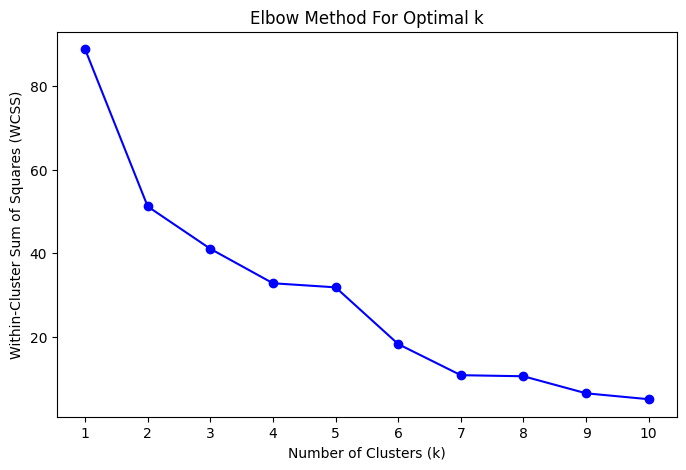

In [123]:
# Range of clusters to try
k_values = range(1, 11)
wcss = []  # List to store Within-Cluster Sum of Squares

# Calculate WCSS for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='blue')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.show()

## Kmeans

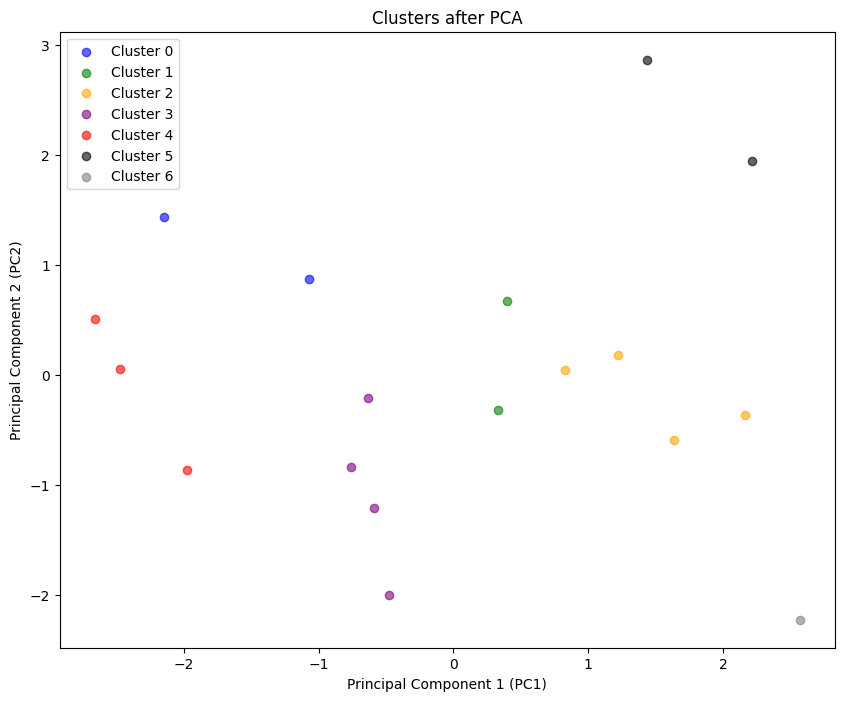

In [124]:


# Apply K-Means Clustering
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(data_pca)

cluster_colors = {0: 'blue', 1: 'green', 2: 'orange', 3: 'purple', 4: 'red', 5: 'black', 6: 'grey'}

plt.figure(figsize=(10,8))
for cluster, color in cluster_colors.items():
    subset = data_pca[clusters == cluster]
    plt.scatter(subset[:, 0], subset[:, 1], color=color, label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('Clusters after PCA')
plt.legend()
plt.show()

In [125]:
# Creating a DataFrame to inspect the principal components resulting from PCA transformation

pd.DataFrame(pca.components_, columns=cluster_feature.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

,last_x1,x1/x2,x2_cumulative_min,avg_contract_length,longest_contract,total_contract_count
PC1,0.079406,-0.446259,-2.220446e-16,0.496967,0.593543,-0.441903
PC2,0.760855,0.308140,5.551115e-17,0.381429,0.115140,0.409151
PC3,-0.120990,0.778490,-6.106227e-16,0.229961,-0.016248,-0.571112
PC4,-0.598108,0.069072,8.049117e-16,0.637352,-0.045238,0.478782


In [126]:
# Getting the cluster centers from the KMeans model after clustering in the PCA-transformed space
cluster_centers_pca = kmeans.cluster_centers_
pd.DataFrame(pca.inverse_transform(cluster_centers_pca), columns=cluster_feature.columns)

,last_x1,x1/x2,x2_cumulative_min,avg_contract_length,longest_contract,total_contract_count
0,1.099564,0.478000,5.206744e-16,-0.801241,-0.791430,1.396256
1,0.314193,-0.755841,3.622403e-16,0.005929,0.255224,0.339426
2,0.107382,-0.398152,-8.370478e-16,0.563221,0.853793,-1.107365
3,-0.768858,0.088132,-1.913061e-16,-0.784445,-0.482950,-0.362608
4,-0.604919,1.405852,6.385168e-16,-0.806345,-1.447361,0.985250
5,1.631643,0.221279,-6.348263e-17,2.226880,1.331885,0.233560
6,-1.630136,-2.864351,5.590012e-16,0.440793,1.267356,-1.014343


In [127]:
cluster_average_all['cluster'] = clusters

In [128]:
cluster_average_all['Final_Profile'] = cluster_average_all['cluster'].replace({
    0: "Big Fish",
    1: "Hidden Gem",
    2: "Rising Legacy",
    3: "Fairweather Friend",
    4: "Small Fish",
    5: "Legacy",
    6: "Silent Volcano"   
})

profile_breakdown = cluster_average_all[['Category_Combo2', 'Final_Profile']].drop_duplicates().groupby('Final_Profile')['Category_Combo2'].apply(list)
for profile, categories in profile_breakdown.items():
    print(f"\n📌 {profile} ({len(categories)} groups):")
    print(categories)


📌 Big Fish (2 groups):
['B-B', 'D-B']

📌 Fairweather Friend (4 groups):
['B-C', 'B-D', 'C-C', 'C-D']

📌 Hidden Gem (2 groups):
['A-B', 'C-B']

📌 Legacy (2 groups):
['A-N/A', 'B-N/A']

📌 Rising Legacy (4 groups):
['A-A', 'A-C', 'A-D', 'B-A']

📌 Silent Volcano (1 groups):
['C-A']

📌 Small Fish (3 groups):
['D-A', 'D-C', 'D-D']


📌 Big Fish (2 groups):
['B-B', 'D-B']

📌 Fairweather Friend (4 groups):
['B-C', 'B-D', 'C-C', 'C-D']

📌 Hidden Gem (2 groups):
['A-B', 'C-B']

📌 Legacy (2 groups):
['A-N/A', 'B-N/A']

📌 Rising Legacy (4 groups):
['A-A', 'A-C', 'A-D', 'B-A']

📌 Silent Volcano (1 groups):
['C-A']

📌 Small Fish (3 groups):
['D-A', 'D-C', 'D-D']


In [129]:
cluster_plot = cluster_average_all[[
    'Category_Combo2','cluster','last_x1', 'x1/x2', 'x2_cumulative_min', 
    'avg_contract_length', 'longest_contract', 'total_contract_count']]

In [130]:
cluster_plot.groupby('cluster')[['last_x1', 'x1/x2', 'x2_cumulative_min', 
    'avg_contract_length', 'longest_contract', 'total_contract_count']].agg('mean')

,last_x1,x1/x2,x2_cumulative_min,avg_contract_length,longest_contract,total_contract_count
cluster,,,,,,
0,4.833333,3.178702,2.0,12.736558,16.041667,3.333333
1,4.000000,2.866667,2.0,16.594213,29.000000,3.000000
2,3.791667,2.968750,2.0,19.706250,35.145833,2.500000
3,3.041667,3.059776,2.0,13.116609,18.062500,2.708333
4,3.111111,3.462963,2.0,12.000000,12.111111,3.222222
5,5.375000,3.097354,2.0,30.340278,35.916667,2.916667
6,2.166667,2.258207,2.0,19.722222,36.666667,2.500000


## Spectral Cluster

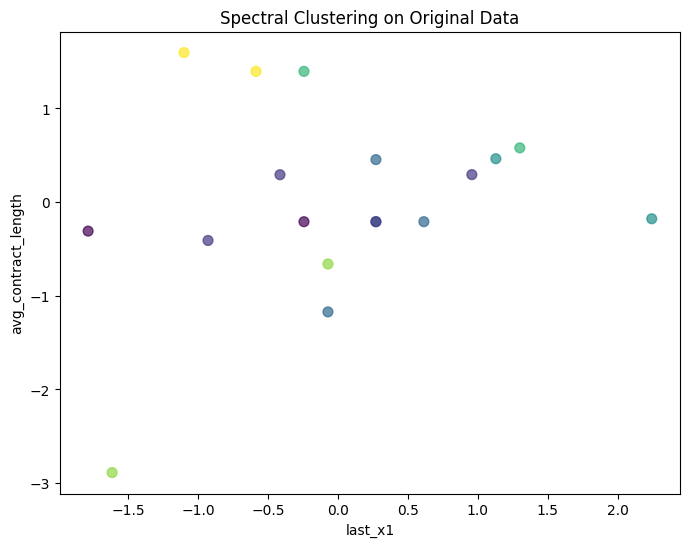

In [131]:
# Ensure the data is in array format
#X = data_pca.to_numpy()

# Spectral Clustering
sc = SpectralClustering(n_clusters=7, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
clusters2 = sc.fit_predict(data_scaled)

# Plot using meaningful features (or first two PCA components)
plt.figure(figsize=(8, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=clusters2, cmap='viridis', s=50, alpha=0.7)
plt.xlabel('last_x1')   # Update to match actual feature names
plt.ylabel('avg_contract_length')
plt.title('Spectral Clustering on Original Data')
plt.show()


In [132]:
cluster_average_all['cluster2'] = clusters2

In [133]:
cluster_average_all.groupby('cluster2')[['last_x1', 'x1/x2', 'x2_cumulative_min', 
    'avg_contract_length', 'longest_contract', 'total_contract_count']].agg('mean')

,last_x1,x1/x2,x2_cumulative_min,avg_contract_length,longest_contract,total_contract_count
cluster2,,,,,,
0,2.750000,2.986111,2.0,16.368056,27.208333,2.500000
1,3.708333,3.055621,2.0,14.257118,21.625000,2.833333
2,4.000000,2.979221,2.0,16.376562,28.208333,2.833333
3,5.375000,3.097354,2.0,30.340278,35.916667,2.916667
4,4.250000,3.331349,2.0,12.011905,12.333333,3.500000
5,2.916667,2.566604,2.0,21.190278,36.666667,2.416667
6,2.916667,3.472222,2.0,12.000000,12.083333,3.083333


In [134]:
silhouette_kmeans = silhouette_score(data_pca, clusters)
silhouette_spectral = silhouette_score(data_scaled, clusters2)

In [135]:
print(f"KMeans Silhouette: {silhouette_kmeans:.4f}")
print(f"Spectral Silhouette: {silhouette_spectral:.4f}")
# KMeans has lower Silhouette score, we decide to use KMeans instead of Spectral 

KMeans Silhouette: 0.3260
Spectral Silhouette: -0.0061
KMeans Silhouette: 0.3260
Spectral Silhouette: -0.0061


# Kaplan-Meier Estimator

In [136]:
clean.head()

,id,join_date,contract_end_date,target_label,target_date,last_x1,last_x2,x1_cumulative,x2_cumulative,cat1,cat2,cat3,remain_contract_month,year,month,day,life,x1/x2,x1_renew_time,x2_renew_time,x1_mean,x1_median,x1_min,x1_max,x1_std,x2_mean,x2_median,x2_min,x2_max,x2_std,x1_cumulative_mean,x1_cumulative_median,x1_cumulative_min,x1_cumulative_max,x1_cumulative_std,x2_cumulative_mean,x2_cumulative_median,x2_cumulative_min,x2_cumulative_max,x2_cumulative_std,avg_contract_length,longest_contract,shortest_contract,std_contract_length,last_contract_length,last_avg_contract_ratio,total_contract_count,Category_Combo2
0,000ab9309fc049b1b0025e55204b413f,2013-03-31,2025-03-31,0.0,NaT,4.0,4.0,68.0,8.0,D,B,Other,6.0,2025.0,3.0,31.0,139.0,8.500000,17.000000,2.000000,6.906475,8.0,4.0,12.0,3.016602,4.201439,4.0,4.0,8.0,0.877908,38.223022,40.0,8.0,68.0,20.096161,5.669065,4.0,4.0,8.0,1.979564,11.357143,13.0,4.0,2.437121,13.0,1.144654,14,D-B
1,000fdf86eb30848cf9cdf2ecdc6ff063,2022-03-31,2027-02-28,0.0,NaT,4.0,4.0,8.0,6.0,A,B,E,29.0,2027.0,2.0,28.0,31.0,1.333333,2.000000,1.500000,3.290323,4.0,0.0,4.0,1.418768,2.258065,2.0,0.0,4.0,1.237410,5.032258,4.0,4.0,8.0,1.779211,3.032258,2.0,2.0,6.0,1.779211,20.000000,36.0,12.0,13.856406,36.0,1.800000,3,A-B
2,0016c95adcdd55040dc65e12da5272d1,2011-10-31,2025-07-31,0.0,NaT,274.0,74.0,364.0,79.0,A,B,B,10.0,2025.0,7.0,31.0,156.0,4.607595,1.328467,1.067568,24.852564,10.0,4.0,274.0,51.966714,9.141026,5.0,2.0,74.0,13.272552,62.352564,46.0,4.0,364.0,71.344851,11.141026,9.0,2.0,79.0,14.264980,12.523810,18.0,9.0,2.293884,12.0,0.958175,21,A-B
3,00171e9f7615c2a107e3f279bb278240,2012-09-30,2026-08-31,0.0,NaT,12.0,6.0,79.0,15.0,A,B,B,23.0,2026.0,8.0,31.0,145.0,5.266667,6.583333,2.500000,11.944828,14.0,2.0,23.0,5.892296,6.344828,7.0,2.0,11.0,2.215411,41.427586,34.0,4.0,79.0,25.823317,9.241379,9.0,2.0,15.0,3.942778,29.142857,49.0,11.0,16.308833,49.0,1.681373,14,A-B
4,0018a2948dc42c760f015e247b697629,2017-09-30,2025-03-31,0.0,NaT,4.0,4.0,37.0,4.0,D,B,B,6.0,2025.0,3.0,31.0,85.0,9.250000,9.250000,1.000000,5.988235,6.0,3.0,10.0,2.217324,3.905882,4.0,2.0,4.0,0.331789,21.305882,21.0,4.0,37.0,8.762778,3.976471,4.0,2.0,4.0,0.216930,10.090909,12.0,3.0,3.562430,12.0,1.189189,11,D-B


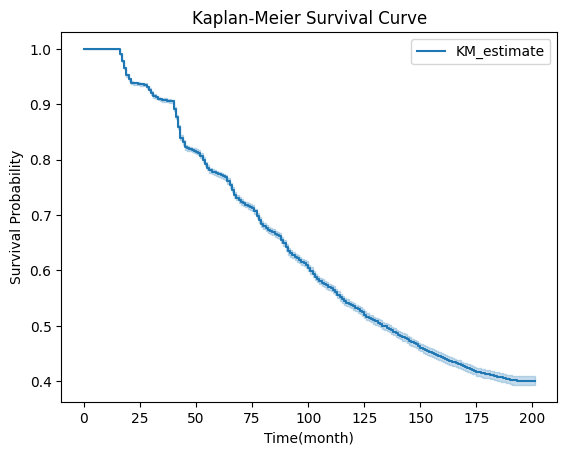

In [137]:
# Prepare data
T = clean['life']  # Time to event (e.g., duration in days)
E = clean['target_label']  # Event indicator (1=event occurred, 0=censored)

# Fit Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

# Plot survival curve
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time(month)')
plt.ylabel('Survival Probability')
plt.show()

# Cox Proportional Hazards Model
Once a Cox model is fitted, you can generate survival curves based on specific predictor values.

'last_x1': [20], 'last_x2': [20],  
'x1_cumulative': [50], 'x2_cumulative': [50]

/opt/homebrew/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


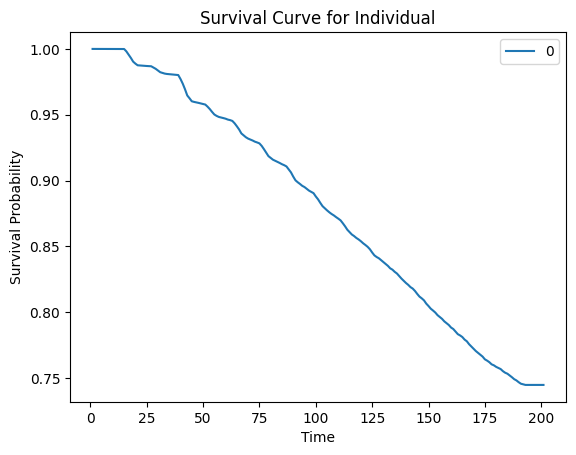

In [138]:
# Fit Cox Proportional Hazards model
cox_df = clean[['life', 'target_label', 'last_x1', 'last_x2', 'x1_cumulative', 'x2_cumulative']]
cox = CoxPHFitter()
cox.fit(cox_df, duration_col='life', event_col='target_label')

# Predict survival function for a specific individual
individual = pd.DataFrame({
    'last_x1': [20],
    'last_x2': [20],
    'x1_cumulative': [50],
    'x2_cumulative': [50]
})
survival_curve = cox.predict_survival_function(individual)

# Plot survival curve
survival_curve.plot()
plt.title('Survival Curve for Individual')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

'last_x1': [2], 'last_x2': [2],  
'x1_cumulative': [5], 'x2_cumulative': [5]

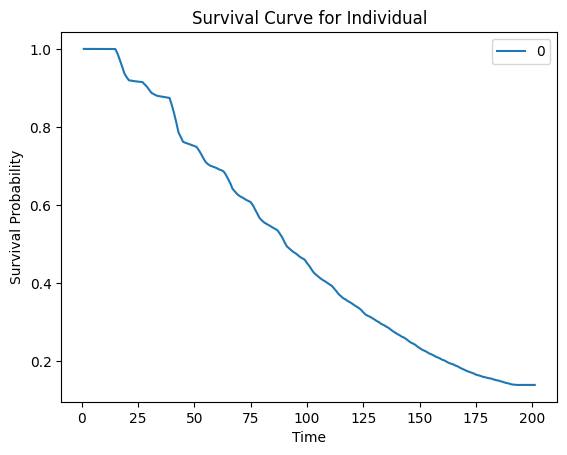

In [139]:
individual = pd.DataFrame({
    'last_x1': [2],
    'last_x2': [2],
    'x1_cumulative': [5],
    'x2_cumulative': [5]
})
survival_curve = cox.predict_survival_function(individual)

# Plot survival curve
survival_curve.plot()
plt.title('Survival Curve for Individual')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

# Comparing Groups
To compare survival curves for groups

In [140]:
clean['Category_Combo'] = clean['cat1'] + '-' + clean['cat2'] + '-' + clean['cat3']

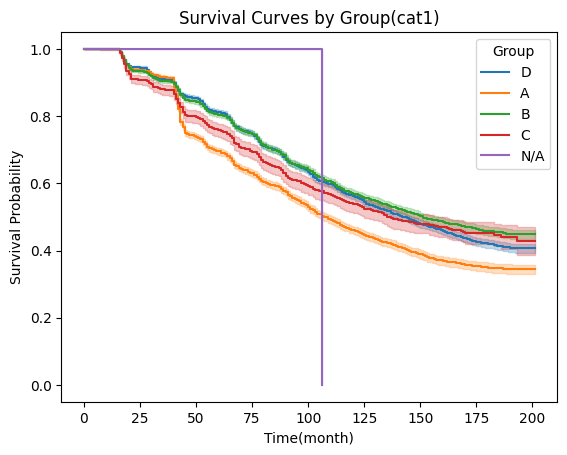

In [141]:
for group in clean['cat1'].unique():
    group_data = clean[clean['cat1'] == group]
    kmf.fit(group_data['life'], event_observed=group_data['target_label'], label=str(group))
    kmf.plot_survival_function()

plt.title('Survival Curves by Group(cat1)')
plt.xlabel('Time(month)')
plt.ylabel('Survival Probability')
plt.legend(title='Group')
plt.show()

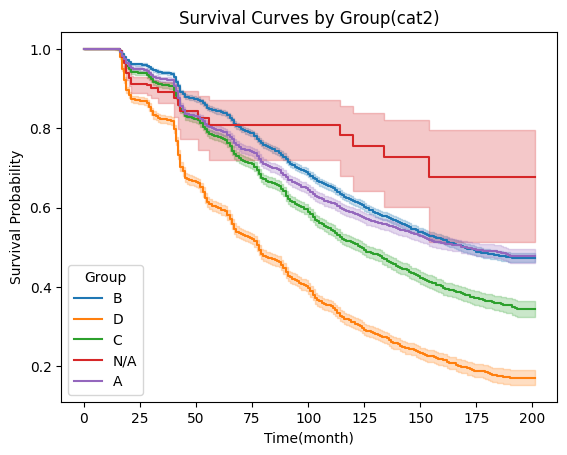

In [142]:
for group in clean['cat2'].unique():
    group_data = clean[clean['cat2'] == group]
    kmf.fit(group_data['life'], event_observed=group_data['target_label'], label=str(group))
    kmf.plot_survival_function()

plt.title('Survival Curves by Group(cat2)')
plt.xlabel('Time(month)')
plt.ylabel('Survival Probability')
plt.legend(title='Group')
plt.show()

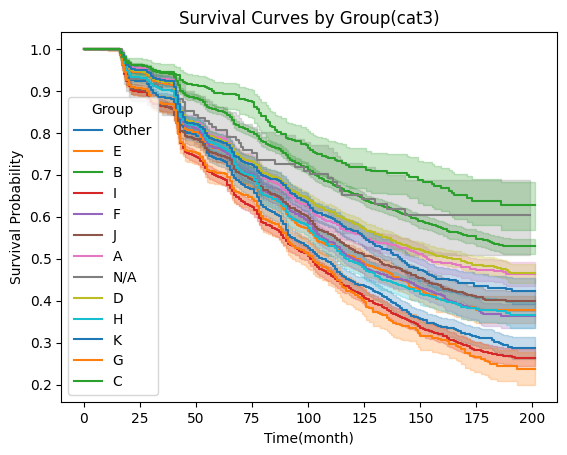

In [143]:
for group in clean['cat3'].unique():
    group_data = clean[clean['cat3'] == group]
    kmf.fit(group_data['life'], event_observed=group_data['target_label'], label=str(group))
    kmf.plot_survival_function()

plt.title('Survival Curves by Group(cat3)')
plt.xlabel('Time(month)')
plt.ylabel('Survival Probability')
plt.legend(title='Group')
plt.show()

# Statistical Comparison of three categories survival curves using Log-Rank Test

In [144]:
# Get the unique groups in cat1
groups_cat1 = clean['cat1'].unique()

# Pairwise log-rank tests for all group combinations in cat1
for i in range(len(groups_cat1)):
    for j in range(i + 1, len(groups_cat1)):
        group1 = clean[clean['cat1'] == groups_cat1[i]]
        group2 = clean[clean['cat1'] == groups_cat1[j]]
        
        # Perform log-rank test
        result = logrank_test(
            group1['life'], group2['life'],
            event_observed_A=group1['target_label'],
            event_observed_B=group2['target_label']
        )
        
        print(f"Log-rank test between {groups_cat1[i]} and {groups_cat1[j]}:")
        print(f"P-value: {result.p_value}\n")


Log-rank test between D and A:
P-value: 1.0076788104301208e-47

Log-rank test between D and B:
P-value: 0.028076330425757894

Log-rank test between D and C:
P-value: 0.02858365638884909

Log-rank test between D and N/A:
P-value: 0.4796101392333668

Log-rank test between A and B:
P-value: 3.477080943007986e-60

Log-rank test between A and C:
P-value: 4.3346672450008235e-08

Log-rank test between A and N/A:
P-value: 0.6967235760684789

Log-rank test between B and C:
P-value: 0.001268507189164514

Log-rank test between B and N/A:
P-value: 0.4573695448052326

Log-rank test between C and N/A:
P-value: 0.5418663755155275

Log-rank test between D and A:
P-value: 1.0076788104301208e-47

Log-rank test between D and B:
P-value: 0.028076330425757894

Log-rank test between D and C:
P-value: 0.02858365638884909

Log-rank test between D and N/A:
P-value: 0.4796101392333668

Log-rank test between A and B:
P-value: 3.477080943007986e-60

Log-rank test between A and C:
P-value: 4.3346672450008235e-08



Significant Comparisons (p < 0.05):
- D vs A (p = 2.6e-49): Strong evidence of a difference.
- D vs B (p = 0.0349): Moderate evidence of a difference.
- D vs C (p = 0.0078): Strong evidence of a difference.
- A vs B (p = 1.6e-61): Extremely strong evidence of a difference.
- A vs C (p = 1.85e-07): Strong evidence of a difference.
- B vs C (p = 0.00023): Strong evidence of a difference.

Non-Significant Comparisons (p ≥ 0.05):
- D vs N/A (p = 0.5006): No evidence of a difference.
- A vs N/A (p = 0.7213): No evidence of a difference.
- B vs N/A (p = 0.4765): No evidence of a difference.
- C vs N/A (p = 0.5690): No evidence of a difference.

In [145]:
groups_cat2 = clean['cat2'].unique()

for i in range(len(groups_cat2)):
    for j in range(i + 1, len(groups_cat2)):
        group1 = clean[clean['cat2'] == groups_cat2[i]]
        group2 = clean[clean['cat2'] == groups_cat2[j]]
        
        result = logrank_test(
            group1['life'], group2['life'],
            event_observed_A=group1['target_label'],
            event_observed_B=group2['target_label']
        )
        
        print(f"Log-rank test between {groups_cat2[i]} and {groups_cat2[j]}:")
        print(f"P-value: {result.p_value}\n")


Log-rank test between B and D:
P-value: 0.0

Log-rank test between B and C:
P-value: 3.7824841320305575e-51

Log-rank test between B and N/A:
P-value: 0.004666756204768046

Log-rank test between B and A:
P-value: 8.449524238608668e-05

Log-rank test between D and C:
P-value: 2.359597247160244e-131

Log-rank test between D and N/A:
P-value: 1.4727586062281746e-11

Log-rank test between D and A:
P-value: 1.040275031944587e-232

Log-rank test between C and N/A:
P-value: 0.5066119816896153

Log-rank test between C and A:
P-value: 1.155365382863522e-19

Log-rank test between N/A and A:
P-value: 0.24440624306709466

Log-rank test between B and D:
P-value: 0.0

Log-rank test between B and C:
P-value: 3.7824841320305575e-51

Log-rank test between B and N/A:
P-value: 0.004666756204768046

Log-rank test between B and A:
P-value: 8.449524238608668e-05

Log-rank test between D and C:
P-value: 2.359597247160244e-131

Log-rank test between D and N/A:
P-value: 1.4727586062281746e-11

Log-rank test be

Significant Comparisons (p < 0.05):
- B vs D (p = 0.0): Indicates a very strong difference in survival patterns.
- B vs C (p = 1.88e-51): Extremely strong evidence of a difference.
- B vs N/A (p = 0.0193): Moderate evidence of a difference.
- B vs A (p = 2.2e-05): Strong evidence of a difference.
- D vs C (p = 1.17e-139): Extremely strong evidence of a difference.
- D vs N/A (p = 6.3e-14): Extremely strong evidence of a difference.
- D vs A (p = 1.28e-240): Extremely strong evidence of a difference.
- C vs A (p = 1.25e-18): Strong evidence of a difference.

Non-Significant Comparisons (p ≥ 0.05):
- C vs N/A (p = 0.296): No evidence of a difference.
- N/A vs A (p = 0.414): No evidence of a difference.

In [146]:
groups_cat3 = clean['cat3'].unique()

for i in range(len(groups_cat3)):
    for j in range(i + 1, len(groups_cat3)):
        group1 = clean[clean['cat3'] == groups_cat3[i]]
        group2 = clean[clean['cat3'] == groups_cat3[j]]
        
        result = logrank_test(
            group1['life'], group2['life'],
            event_observed_A=group1['target_label'],
            event_observed_B=group2['target_label']
        )
        
        # print(f"Log-rank test between {groups_cat3[i]} and {groups_cat3[j]}:")
        # print(f"P-value: {result.p_value}\n")


# Feature Engineering

uses cox proportional hazards model

## Removing inconsistent id's

hardcoded removing id's where contract_end_date was incorrectly inputted and later "revised" but became a new data entry in 2020. paige will create a solution later.

In [147]:
# Prepare the predictor variables
cleaning_X = clean.drop(columns=['join_date', 'contract_end_date', 'target_label', 'target_date', 'life', 
                        'cat1', 'cat2', 'cat3', 'x2_cumulative', 'x1_cumulative', 'remain_contract_month', 'year', 'month', 'day'])

cleaning_X.head()


,id,last_x1,last_x2,x1/x2,x1_renew_time,x2_renew_time,x1_mean,x1_median,x1_min,x1_max,x1_std,x2_mean,x2_median,x2_min,x2_max,x2_std,x1_cumulative_mean,x1_cumulative_median,x1_cumulative_min,x1_cumulative_max,x1_cumulative_std,x2_cumulative_mean,x2_cumulative_median,x2_cumulative_min,x2_cumulative_max,x2_cumulative_std,avg_contract_length,longest_contract,shortest_contract,std_contract_length,last_contract_length,last_avg_contract_ratio,total_contract_count,Category_Combo2,Category_Combo
0,000ab9309fc049b1b0025e55204b413f,4.0,4.0,8.500000,17.000000,2.000000,6.906475,8.0,4.0,12.0,3.016602,4.201439,4.0,4.0,8.0,0.877908,38.223022,40.0,8.0,68.0,20.096161,5.669065,4.0,4.0,8.0,1.979564,11.357143,13.0,4.0,2.437121,13.0,1.144654,14,D-B,D-B-Other
1,000fdf86eb30848cf9cdf2ecdc6ff063,4.0,4.0,1.333333,2.000000,1.500000,3.290323,4.0,0.0,4.0,1.418768,2.258065,2.0,0.0,4.0,1.237410,5.032258,4.0,4.0,8.0,1.779211,3.032258,2.0,2.0,6.0,1.779211,20.000000,36.0,12.0,13.856406,36.0,1.800000,3,A-B,A-B-E
2,0016c95adcdd55040dc65e12da5272d1,274.0,74.0,4.607595,1.328467,1.067568,24.852564,10.0,4.0,274.0,51.966714,9.141026,5.0,2.0,74.0,13.272552,62.352564,46.0,4.0,364.0,71.344851,11.141026,9.0,2.0,79.0,14.264980,12.523810,18.0,9.0,2.293884,12.0,0.958175,21,A-B,A-B-B
3,00171e9f7615c2a107e3f279bb278240,12.0,6.0,5.266667,6.583333,2.500000,11.944828,14.0,2.0,23.0,5.892296,6.344828,7.0,2.0,11.0,2.215411,41.427586,34.0,4.0,79.0,25.823317,9.241379,9.0,2.0,15.0,3.942778,29.142857,49.0,11.0,16.308833,49.0,1.681373,14,A-B,A-B-B
4,0018a2948dc42c760f015e247b697629,4.0,4.0,9.250000,9.250000,1.000000,5.988235,6.0,3.0,10.0,2.217324,3.905882,4.0,2.0,4.0,0.331789,21.305882,21.0,4.0,37.0,8.762778,3.976471,4.0,2.0,4.0,0.216930,10.090909,12.0,3.0,3.562430,12.0,1.189189,11,D-B,D-B-B


In [148]:
null_ids = cleaning_X[cleaning_X['last_avg_contract_ratio'].isna()]['id']
null_ids

Series([], Name: id, dtype: object)

In [149]:
clean = clean[~clean['id'].isin(null_ids)]

## Choosing important features

In [150]:
# Prepare survival target
y = Surv.from_dataframe('target_label', 'life', clean)

# Prepare the predictor variables
X = clean.drop(columns=['id', 'join_date', 'contract_end_date', 'target_label', 'target_date', 'life', 
                        'cat1', 'cat2', 'cat3', 'x2_cumulative', 'x1_cumulative', 'remain_contract_month', 'year', 'month', 'day'])


# Train-test split (80% train, 20% test) - stratify using the event column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=clean['target_label'])

# Train the Cox Proportional Hazards Model
cox_model = CoxPHSurvivalAnalysis(tol=1e-6, alpha=0.1)  # Using penalization to prevent overfitting
cox_model.fit(X_train, y_train)

# Evaluate on test set using concordance index
c_index_test = concordance_index_censored(y_test['target_label'], y_test['life'], cox_model.predict(X_test))[0]
print(f"Test C-index: {c_index_test:.4f}")

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = []

for train_idx, val_idx in cv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]  # Directly indexing `y_train`
    
    # Fit model on training data
    cox_model.fit(X_tr, y_tr)
    
    # Predict on validation data and compute C-index
    c_index = concordance_index_censored(y_val['target_label'], y_val['life'], cox_model.predict(X_val))[0]
    cv_scores.append(c_index)

print(f"Cross-validation C-index scores: {cv_scores}")
print(f"Mean C-index (cross-validation): {np.mean(cv_scores):.4f}")

ValueError: could not convert string to float: 'B-A'

### Importance

In [ ]:
# Extract Feature Importance (Coefficients)
importance_df = pd.DataFrame({
    'covariate': X.columns,
    'Importance': cox_model.coef_
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['covariate'], importance_df['Importance'])
plt.xlabel('Feature Importance (Coefficients)')
plt.title('Feature Importance from Cox Proportional Hazards Model')
plt.show()

### MultiCollinearity

In [151]:
vif_data = pd.DataFrame()
vif_data["covariate"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### P-values

In [ ]:
# Convert data to lifelines format
lifelines_df = clean.drop(columns=['id', 'join_date', 'contract_end_date', 'target_date', 'cat1', 'cat2', 'cat3','remain_contract_month', 'year', 'month', 'day'])
lifelines_df['event'] = lifelines_df['target_label']
lifelines_df['time'] = lifelines_df['life']

# Fit Cox model using lifelines
cph = CoxPHFitter()
cph.fit(lifelines_df, duration_col='time', event_col='event')

# Print summary (includes coefficients, standard errors, and p-values)
print(cph.summary)

#### Significant features using P-value

In [152]:
# Fit Cox model using lifelines
cph = CoxPHFitter()
cph.fit(lifelines_df, duration_col='time', event_col='event')

# Print summary (includes coefficients, standard errors, and p-values)
summary_df = cph.summary

# Filter for features with p-value < 0.05 (significant)
feature_significance = summary_df[['p']]  # Keep all needed columns
feature_significance

NameError: name 'lifelines_df' is not defined

### Final set of important features

In [ ]:
important_features = feature_significance
important_features = important_features.merge(vif_data, on='covariate')
important_features = important_features.merge(importance_df, on='covariate')
important_features['Importance'] = abs(important_features['Importance'])

In [153]:
important_features = important_features[important_features['p'] < 0.05]
important_features.sort_values(by='VIF')
important_features = important_features[important_features['Importance'] > 0.05]
important_features

TypeError: list indices must be integers or slices, not str

## Model using CHOSEN Important Features

In [ ]:
# Prepare the survival target (ensure correct column names)
y = Surv.from_dataframe('target_label', 'life', clean)

# Prepare the predictor variables
X = clean[['last_x1', 'x1/x2', 'x2_cumulative_min', 'last_avg_contract_ratio', 'longest_contract', 'total_contract_count']]

# Train-test split (80% train, 20% test) - stratify using the event column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=clean['target_label'])

# Train the Cox Proportional Hazards Model
cox_model = CoxPHSurvivalAnalysis(tol=1e-6, alpha=0.1)  # Using penalization to prevent overfitting
cox_model.fit(X_train, y_train)

# Evaluate on test set using concordance index
c_index_test = concordance_index_censored(y_test['target_label'], y_test['life'], cox_model.predict(X_test))[0]
print(f"Test C-index: {c_index_test:.4f}")

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = []

for train_idx, val_idx in cv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]  # Directly indexing `y_train`
    
    # Fit model on training data
    cox_model.fit(X_tr, y_tr)
    
    # Predict on validation data and compute C-index
    c_index = concordance_index_censored(y_val['target_label'], y_val['life'], cox_model.predict(X_val))[0]
    cv_scores.append(c_index)

print(f"Cross-validation C-index scores: {cv_scores}")
print(f"Mean C-index (cross-validation): {np.mean(cv_scores):.4f}")

In [154]:
# Extract Feature Importance (Coefficients)
importance_df = pd.DataFrame({
    'covariate': X.columns,
    'Importance': cox_model.coef_
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['covariate'], importance_df['Importance'])
plt.xlabel('Feature Importance (Coefficients)')
plt.title('Feature Importance from Cox Proportional Hazards Model')
plt.show()

AttributeError: 'CoxPHSurvivalAnalysis' object has no attribute 'coef_'

In [ ]:
# Convert data to lifelines format
lifelines_df = clean[['target_label', 'life', 'last_x1', 'x1/x2', 'x2_cumulative_min', 'last_avg_contract_ratio', 'last_peak_contract_ratio', 'total_contract_count']]
lifelines_df['event'] = lifelines_df['target_label']
lifelines_df['time'] = lifelines_df['life']

# Fit Cox model using lifelines
cph = CoxPHFitter()
cph.fit(lifelines_df, duration_col='time', event_col='event')

# Print summary (includes coefficients, standard errors, and p-values)
print(cph.summary)

In [155]:
# Fit Cox model using lifelines
cph = CoxPHFitter()
cph.fit(lifelines_df, duration_col='time', event_col='event')

# Print summary (includes coefficients, standard errors, and p-values)
summary_df = cph.summary

# Filter for features with p-value < 0.05 (significant)
feature_significance = summary_df[['p']]  # Keep all needed columns
feature_significance

NameError: name 'lifelines_df' is not defined

In [ ]:
vif_data = pd.DataFrame()
vif_data["covariate"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

### Chosen Important Features

In [156]:
important_features_chosen = feature_significance
important_features_chosen = important_features_chosen.merge(vif_data, on='covariate')
important_features_chosen = important_features_chosen.merge(importance_df, on='covariate')
important_features_chosen['Importance_Interpret'] = important_features_chosen['Importance']
important_features_chosen['Importance'] = abs(important_features_chosen['Importance'])

important_features_chosen.sort_values('Importance_Interpret', ascending=False)
important_features_chosen

NameError: name 'feature_significance' is not defined

In [ ]:
important_features_chosen['covariate'].tolist()

# COX PROPORTIONAL MODEL

In [157]:
important_features = [
    'last_x1', 'x1/x2', 'x2_cumulative_min', 
    'avg_contract_length', 'longest_contract', 'total_contract_count']

# Prepare the survival target
y = Surv.from_dataframe("target_label", "life", clean)

# Prepare the predictor variables using only the important features
X = clean[important_features]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=clean["target_label"]
)

# Train the Cox Proportional Hazards Model
cox_model = CoxPHSurvivalAnalysis(tol=1e-6, alpha=0.1)  # L2 Regularization to prevent overfitting
cox_model.fit(X_train, y_train)

CoxPHSurvivalAnalysis(alpha=0.1, tol=1e-06)

In [158]:
# Extract 'life' (event/censoring time) from y_test
life_values = y_test["life"]  

# Get the maximum observed time from training data
max_time = y_train["life"].max()

# Create a dictionary to store predictions
future_predictions = {"life + 12": [], "life + 18": [], "life + 24": [], "life + 36": []}

# Get survival functions for each customer
survival_functions = cox_model.predict_survival_function(X_test)

# Define future time points in absolute months (not adding to customer age)
time_offsets = [12, 18, 24, 36]  # Months

# Iterate over each individual's survival function and life time
for fn, life in zip(survival_functions, y_test["life"]):
    
    # Predict survival probability at life + t (but cap at max_time)
    for t in time_offsets:
        adjusted_time = min(life + t, max_time)  # Ensure we don't exceed max_time
        future_predictions[f"life + {t}"].append(fn(adjusted_time))  # Use adjusted time


# Convert predictions to DataFrame
future_pred_df = pd.DataFrame(future_predictions, index=X_test.index)

# Retrieve customer IDs from the original dataset
customer_ids = clean.loc[X_test.index, "id"]

# Add Customer IDs to the predictions DataFrame
future_pred_df["id"] = customer_ids

# Move 'Customer ID' to the first column for better readability
future_pred_df = future_pred_df.set_index("id")

# Display first few rows
print(future_pred_df.head(10))




                                  life + 12  ...  life + 36
id                                           ...           
59b26cf177a8b5df48cd6618924e2491   0.438634  ...   0.044961
773a41d08fc035fbcfa88ff87fc359d3   0.992250  ...   0.000000
6baedc27fd19d2b8a232cdcdc8d82b0e   0.000000  ...   0.000000
15a43c8a07f13f816bb34571d6fc64e7   0.000000  ...   0.000000
fb99f37ae74bfc19584920d826a38a0f   0.826042  ...   0.335737
6dbd0c0d8bcac1fe25530ff0a0d0efc8   0.959695  ...   0.000000
6cefc0d685a1087f1d310ef5ea341cf9   0.999919  ...   0.000000
f18156bf78855f1e887d04fcfb8c24d5   0.387463  ...   0.004938
ea658e4a76699a426f456bdf560aa19f   0.962289  ...   0.825898
38c41e72b345bf0f78551b3d84adcde8   0.000000  ...   0.000000

[10 rows x 4 columns]
                                  life + 12  ...  life + 36
id                                           ...           
59b26cf177a8b5df48cd6618924e2491   0.438634  ...   0.044961
773a41d08fc035fbcfa88ff87fc359d3   0.992250  ...   0.000000
6baedc27fd19d2b8a

## integrated brier score for cox proportional model

In [159]:

# Convert y_train and y_test into structured arrays for sksurv compatibility
survival_train = np.array([(event, time) for event, time in zip(y_train["target_label"], y_train["life"])],
                          dtype=[('event', bool), ('time', float)])

survival_test = np.array([(event, time) for event, time in zip(y_test["target_label"], y_test["life"])],
                         dtype=[('event', bool), ('time', float)])

# Define time points at which to evaluate the Brier score
times = np.percentile(y_test["life"], np.linspace(10, 90, 20))  # Select meaningful time points

# Predict survival functions for test data
survival_preds = cox_model.predict_survival_function(X_test)

# Convert predictions into an estimate matrix
estimate = np.vstack([fn(times) for fn in survival_preds])

# Compute Brier scores at different time points
brier_scores = brier_score(survival_train, survival_test, estimate, times)

# Extract the Brier scores (second element in the tuple)
brier_scores = brier_scores[1]

# Now compute the Integrated Brier Score
integrated_brier_score = trapezoid(brier_scores, times) / (times.max() - times.min())

# Convert to scalar
integrated_brier_score = float(integrated_brier_score)

print(f"Integrated Brier Score for Cox Model: {integrated_brier_score:.4f}")


Integrated Brier Score for Cox Model: 0.0702
Integrated Brier Score for Cox Model: 0.0702


In [160]:

# Convert y_train and y_test into structured arrays for sksurv compatibility
survival_train = np.array([(event, time) for event, time in zip(y_train["target_label"], y_train["life"])],
                          dtype=[('event', bool), ('time', float)])

survival_test = np.array([(event, time) for event, time in zip(y_test["target_label"], y_test["life"])],
                         dtype=[('event', bool), ('time', float)])

# Define time points at which to evaluate the Brier score
times = np.percentile(y_test["life"], np.linspace(20, 90, 10))  # Select meaningful time points

# Predict survival functions for test data
survival_preds = cox_model.predict_survival_function(X_test)

# Convert predictions into an estimate matrix
estimate = np.row_stack([fn(times) for fn in survival_preds])

# Compute Brier scores at different time points
brier_scores = brier_score(survival_train, survival_test, estimate, times)

# Compute Integrated Brier Score (mean of all time points)
integrated_brier_score = np.mean(brier_scores)

# Display the Integrated Brier Score
print(f"Integrated Brier Score for Cox Model: {integrated_brier_score:.4f}")


Integrated Brier Score for Cox Model: 47.8455
Integrated Brier Score for Cox Model: 47.8455


<positron-console-cell-160>:15: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.


In [161]:
future_pred_df.sort_values(by="life + 36", ascending=True)

,life + 12,life + 18,life + 24,life + 36
id,,,,
02c9a0b396a58b0f7957894b3531320a,0.995839,0.995218,0.994588,0.0
46b5a1098c6c0cdb67381f2206923d50,0.999680,0.999638,0.999583,0.0
9c16d8f6a2207d584a60a654d333eb7f,0.000000,0.000000,0.000000,0.0
3a8418e7c7d2e8988f5edb26f2feb777,0.000000,0.000000,0.000000,0.0
2580e3e5479fddc625bd3dc99823e878,0.370859,0.324362,0.274561,0.0
...,...,...,...,...
6e321eed9aa6fdc5036fbfbb8b83f0ba,1.000000,1.000000,1.000000,1.0
f6cc624ed07c3d7cacfa78fb973c0ee9,1.000000,1.000000,1.000000,1.0
c568b7734dcdc5962cc7c21af6e22150,1.000000,1.000000,1.000000,1.0


In [162]:
sorted_future_cox_36_month = future_pred_df["life + 36"].sort_values(ascending=True)
sorted_future_cox_36_month

id
02c9a0b396a58b0f7957894b3531320a    0.0
46b5a1098c6c0cdb67381f2206923d50    0.0
9c16d8f6a2207d584a60a654d333eb7f    0.0
3a8418e7c7d2e8988f5edb26f2feb777    0.0
2580e3e5479fddc625bd3dc99823e878    0.0
                                   ... 
6e321eed9aa6fdc5036fbfbb8b83f0ba    1.0
f6cc624ed07c3d7cacfa78fb973c0ee9    1.0
c568b7734dcdc5962cc7c21af6e22150    1.0
c5072a5784e43c66b5dcd5763c179433    1.0
b569a6739c5fd08eb3b43f41dde8fabc    1.0
Name: life + 36, Length: 6905, dtype: float64

In [163]:
sorted_future_cox_12_month = future_pred_df["life + 12"].sort_values(ascending=True)
sorted_future_cox_12_month

id
d39ef54720e2d0d7bd6a064eb6c3d250    0.0
76690a6a0448d7bf0d3cc6bb6b2bcf52    0.0
363dc6e95d3b7474b54f00c57d68049c    0.0
260d457243422036d075ead461884ef1    0.0
02f42785e6dc427f1cb2cba530e94be2    0.0
                                   ... 
4c44c197f401dac27ffafc92ccf49fc4    1.0
c568b7734dcdc5962cc7c21af6e22150    1.0
a9948f38d264ac32ece8c63570b5e939    1.0
b569a6739c5fd08eb3b43f41dde8fabc    1.0
c5072a5784e43c66b5dcd5763c179433    1.0
Name: life + 12, Length: 6905, dtype: float64

In [164]:
sorted_future_cox_18_month = future_pred_df["life + 18"].sort_values(ascending=True)
sorted_future_cox_18_month

id
d39ef54720e2d0d7bd6a064eb6c3d250    0.0
d42da7fbe16cbebe9b32eb591c2303b4    0.0
5ae5210a2b25603676b9c09b7c793b1f    0.0
f314b35fc5aff9280657ce42fab0ee92    0.0
f53d3803a4573fd2777d358c8c822518    0.0
                                   ... 
4c44c197f401dac27ffafc92ccf49fc4    1.0
c568b7734dcdc5962cc7c21af6e22150    1.0
c5072a5784e43c66b5dcd5763c179433    1.0
a9948f38d264ac32ece8c63570b5e939    1.0
b569a6739c5fd08eb3b43f41dde8fabc    1.0
Name: life + 18, Length: 6905, dtype: float64

# WEIBULL - uses weibull distribution for future predictions
### this is what we presented in the mid point

In [165]:
# Define predictor features
important_features = [
 'last_x1', 'x1/x2', 'x2_cumulative_min',
 'longest_contract', 'last_avg_contract_ratio', 'total_contract_count']

# Prepare survival target (event indicator and survival time)
y = clean[["life", "target_label"]]  # Target: survival time & event indicator
X = clean[important_features]  # Predictor variables

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y["target_label"]
)


In [166]:
# Fit Weibull AFT Model
aft_model = WeibullAFTFitter()
aft_model.fit(y_train.join(X_train), duration_col="life", event_col="target_label")

# Display model summary
aft_model.print_summary()


<lifelines.WeibullAFTFitter: fitted with 27617 total observations, 15796 right-censored observations>
             duration col = 'life'
                event col = 'target_label'
   number of observations = 27617
number of events observed = 11821
           log-likelihood = -57701.90
         time fit was run = 2025-03-18 18:28:45 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                
lambda_ last_avg_contract_ratio  0.02      1.02      0.01            0.00            0.04                1.00                1.04
        last_x1                  0.02      1.02      0.00            0.02            0.02                1.02                1.02
        longest_contract         0.02      1.02      0.00            0.02            0.02                1.02                1.02
        total_contract_count     0.15      1.16      0.00            0.15            0.15                1.16                1.17
        x1/x2                    0.01      1.01      0.00            0.01            0.01                1.01                1.01
        x2_cumulative_min       -0.02      0.98      0.00           -0.02           -0.02                0.98                0.98
        Intercept                2.93     18.78      0.01            2.90            2.96               18.26               19.30
rho_    Intercept                1.10      3.01      0.01            1.09            1.11                2.98                3.04

                                 cmp to      z      p  -log2(p)
param   covariate                                              
lambda_ last_avg_contract_ratio    0.00   2.40   0.02      5.91
        last_x1                    0.00  16.95 <0.005    211.68
        longest_contract           0.00  87.45 <0.005       inf
        total_contract_count       0.00 109.69 <0.005       inf
        x1/x2                      0.00   7.03 <0.005     38.78
        x2_cumulative_min          0.00 -10.57 <0.005     84.39
        Intercept                  0.00 208.24 <0.005       inf
rho_    Intercept                  0.00 190.38 <0.005       inf
---
Concordance = 0.94
AIC = 115419.80
log-likelihood ratio test = 33262.48 on 6 df
-log2(p) of ll-ratio test = inf

In [167]:
#Filter active customers (target_label != 1)
active_customers = y_test[y_test["target_label"] != 1]

#Extract 'age' of each customer
customer_ages = active_customers["life"]  # Ensure "age" exists in dataset

#Keep corresponding features
X_active = X_test.loc[active_customers.index]

#Define prediction time offsets
time_offsets = [12, 24, 36, 48]

#Dictionary to store predictions
future_aft_predictions = {}

#Iterate over time offsets and predict for each customer's future age
for t in time_offsets:
    future_times = customer_ages + t  # Compute future time for each customer

    #Predict survival function at these specific times for each customer
    survival_probs = np.array([
        aft_model.predict_survival_function(X_active.iloc[i:i+1], times=[future_times.iloc[i]]).values.flatten()[0]
        for i in range(len(X_active))
    ])

    #Store survival probability for each customer at their specific future time
    future_aft_predictions[f"life + {t}"] = survival_probs

#Convert predictions to DataFrame
future_aft_df = pd.DataFrame(future_aft_predictions, index=X_active.index)

# Add customer IDs for reference
customer_ids = clean.loc[X_active.index, "id"]
future_aft_df["id"] = customer_ids

#Move ID column to front
future_aft_df = future_aft_df.set_index("id")

#Display results
future_aft_df

,life + 12,life + 24,life + 36,life + 48
id,,,,
773a41d08fc035fbcfa88ff87fc359d3,0.992365,0.990426,0.988187,0.985627
6baedc27fd19d2b8a232cdcdc8d82b0e,0.803866,0.766891,0.726996,0.684547
15a43c8a07f13f816bb34571d6fc64e7,1.000000,1.000000,1.000000,1.000000
fb99f37ae74bfc19584920d826a38a0f,0.903295,0.685898,0.392006,0.152367
6dbd0c0d8bcac1fe25530ff0a0d0efc8,0.967369,0.958794,0.948901,0.937626
...,...,...,...,...
a506a9e5af00f2f4b059be5c738bca54,0.999260,0.999125,0.998974,0.998807
637cc3e6dc461a67d00d297f9047f040,0.970524,0.962211,0.952529,0.941404
242587a108494eed71353fda249252f2,0.842809,0.723951,0.579293,0.425960


In [168]:
specific_id = "f7194e770adcb3c8e92c8cb79cfc0615"
row = future_aft_df.loc[specific_id]
print(row)

life + 12    0.291731
life + 24    0.137603
life + 36    0.050198
life + 48    0.013635
Name: f7194e770adcb3c8e92c8cb79cfc0615, dtype: float64
life + 12    0.291731
life + 24    0.137603
life + 36    0.050198
life + 48    0.013635
Name: f7194e770adcb3c8e92c8cb79cfc0615, dtype: float64


In [169]:
# Sort DataFrame in ascending order based on 'life + 12' survival probability
sorted_aft_df = future_aft_df.sort_values(by="life + 12", ascending=True)

# Display first few rows
print(sorted_aft_df.head(10))


                                     life + 12  ...     life + 48
id                                              ...              
c5ba2341aaea192aa16128641af92446  1.809097e-45  ...  1.731066e-80
897b35993370add5f78d042337c0fc9b  3.618276e-17  ...  7.580427e-28
62e4af139f93c786bf45e136cfd6c7db  8.084851e-13  ...  3.719953e-23
d624ce10ffb4f48d39af701fafe1f477  5.590089e-11  ...  2.875296e-17
75a871473f9d86ef4800277e90305e88  9.075197e-08  ...  8.667118e-14
f36ebdbf7c9412bd14c348f78faa6177  4.442778e-06  ...  2.333633e-10
eebfae8848a5feceaaca7eb4e3e0fa69  1.138423e-05  ...  4.862449e-09
a5b510456df8d03edce625fca5c486ec  2.400732e-05  ...  2.892622e-09
31d8a2efa5e11d2640b5271e59d1172e  2.482680e-05  ...  9.124259e-09
96e2e484b632422d893fee5d889570b5  2.556980e-05  ...  1.117676e-09

[10 rows x 4 columns]
                                     life + 12  ...     life + 48
id                                              ...              
c5ba2341aaea192aa16128641af92446  1.809097e-45  ...  

## Brier score at A months predicting B months after(Weibull)

In [170]:
train_idx, test_idx = train_test_split(
    clean.index, test_size=0.2, random_state=42, stratify=y["target_label"]
)

# Retrieve the 'id' values for the test set
id_test = clean.loc[test_idx, "id"]

In [171]:
# Time point = A months, predicting B months

A = 156
B = 168

score_df = create_df(df, A, B, id_test)

# Prepare the survival target
score_df_y = Surv.from_dataframe("target_label", "time_step", score_df)

# Prepare the predictor variables using only the important features
score_df_X = score_df[important_features]

# Assume df contains 'time' (event/censoring time) and 'target_label' (churn status)
time_t = B  # Specify the time at which to compute the Brier Score

# Predict survival function for each customer
surv_funcs = aft_model.predict_survival_function(score_df_X)

# Extract survival probability at time_t
surv_probs = surv_funcs.loc[time_t].values

# Compute Brier Score
y_true = 1 - score_df["target_label"]  # Flip 1 → 0 (churned), 0 → 1 (alive)
brier = np.mean((surv_probs - y_true) ** 2)

print(f"Brier Score at t={time_t}: {brier}")

Brier Score at t=168: 0.06075988453496556
Brier Score at t=168: 0.06075988453496556


## Brier, Recall, Precision, Specificity, and Accuracy at A months predicting 12 months after(Weibull)

In [172]:
# Initialize an empty list to store results
results = []

# Loop over A values from 12 to 168 in steps of 12
for A in range(12, 157, 12):  
    B = A + 12  # Define B as A + 12

    score_df = create_df(df, A, B, id_test)

    # Prepare the survival target
    score_df_y = Surv.from_dataframe("target_label", "time_step", score_df)

    # Prepare the predictor variables using only the important features
    score_df_X = score_df[important_features]

    # Assume df contains 'time' (event/censoring time) and 'target_label' (churn status)
    time_t = B  # Specify the time at which to compute the Brier Score

    # Predict survival function for each customer
    surv_funcs = aft_model.predict_survival_function(score_df_X)

    # Extract survival probability at time_t
    surv_probs = surv_funcs.loc[time_t].values

    # Compute Brier Score
    y_true = 1 - score_df["target_label"]  # Flip 1 → 0 (churned), 0 → 1 (alive)
    brier = np.mean((surv_probs - y_true) ** 2)

        # Convert survival probabilities into binary predictions
    y_pred = (surv_probs < 0.6).astype(int)  # Churn if survival probability < 0.5
    y_true_original = score_df["target_label"].values  # Use original labels

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_original, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    # Compute classification metrics
    accuracy = accuracy_score(y_true_original, y_pred)
    precision = precision_score(y_true_original, y_pred, zero_division=0)
    recall = recall_score(y_true_original, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero

    # Store the result
    results.append({
        "Model": "Weibull",
        "Time point": A,
        "Future time": B,
        "Brier Score": round(brier, 3),
        "Accuracy": round(accuracy, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "Specificity": round(specificity, 3)
    })

# Convert results to DataFrame
brier_df_12 = pd.DataFrame(results)
print(brier_df_12)

      Model  Time point  ...  Recall  Specificity
0   Weibull          12  ...   0.354        0.811
1   Weibull          24  ...   0.840        0.659
2   Weibull          36  ...   0.647        0.532
3   Weibull          48  ...   0.849        0.517
4   Weibull          60  ...   0.735        0.542
5   Weibull          72  ...   0.772        0.610
6   Weibull          84  ...   0.659        0.689
7   Weibull          96  ...   0.582        0.749
8   Weibull         108  ...   0.587        0.813
9   Weibull         120  ...   0.418        0.865
10  Weibull         132  ...   0.301        0.889
11  Weibull         144  ...   0.316        0.930
12  Weibull         156  ...   0.125        0.955

[13 rows x 8 columns]
      Model  Time point  ...  Recall  Specificity
0   Weibull          12  ...   0.354        0.811
1   Weibull          24  ...   0.840        0.659
2   Weibull          36  ...   0.647        0.532
3   Weibull          48  ...   0.849        0.517
4   Weibull          60  ..

In [173]:
brier_df_12['Brier Score'].mean()

np.float64(0.1473076923076923)

## Brier, Recall, Precision, Specificity, and Accuracy at A months predicting 24 months after(Weibull)

In [174]:
# Initialize an empty list to store results
results = []

# Loop over A values from 12 to 168 in steps of 12
for A in range(12, 157, 12):  
    B = A + 24  # Define B as A + 24

    score_df = create_df(df, A, B, id_test)

    # Prepare the survival target
    score_df_y = Surv.from_dataframe("target_label", "time_step", score_df)

    # Prepare the predictor variables using only the important features
    score_df_X = score_df[important_features]

    # Assume df contains 'time' (event/censoring time) and 'target_label' (churn status)
    time_t = B  # Specify the time at which to compute the Brier Score

    # Predict survival function for each customer
    surv_funcs = aft_model.predict_survival_function(score_df_X)

    # Extract survival probability at time_t
    surv_probs = surv_funcs.loc[time_t].values

    # Compute Brier Score
    y_true = 1 - score_df["target_label"]  # Flip 1 → 0 (churned), 0 → 1 (alive)
    brier = np.mean((surv_probs - y_true) ** 2)

        # Convert survival probabilities into binary predictions
    y_pred = (surv_probs < 0.6).astype(int)  # Churn if survival probability < 0.5
    y_true_original = score_df["target_label"].values  # Use original labels

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_original, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    # Compute classification metrics
    accuracy = accuracy_score(y_true_original, y_pred)
    precision = precision_score(y_true_original, y_pred, zero_division=0)
    recall = recall_score(y_true_original, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero

    # Store the result
    results.append({
        "Model": "Weibull",
        "Time point": A,
        "Future time": B,
        "Brier Score": round(brier, 3),
        "Accuracy": round(accuracy, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "Specificity": round(specificity, 3)
    })

# Convert results to DataFrame
brier_df_24 = pd.DataFrame(results)
print(brier_df_24)

      Model  Time point  ...  Recall  Specificity
0   Weibull          12  ...   0.954        0.438
1   Weibull          24  ...   0.750        0.375
2   Weibull          36  ...   0.942        0.344
3   Weibull          48  ...   0.855        0.387
4   Weibull          60  ...   0.859        0.461
5   Weibull          72  ...   0.805        0.559
6   Weibull          84  ...   0.737        0.642
7   Weibull          96  ...   0.687        0.718
8   Weibull         108  ...   0.591        0.776
9   Weibull         120  ...   0.465        0.835
10  Weibull         132  ...   0.343        0.896
11  Weibull         144  ...   0.278        0.932
12  Weibull         156  ...   0.204        0.959

[13 rows x 8 columns]
      Model  Time point  ...  Recall  Specificity
0   Weibull          12  ...   0.954        0.438
1   Weibull          24  ...   0.750        0.375
2   Weibull          36  ...   0.942        0.344
3   Weibull          48  ...   0.855        0.387
4   Weibull          60  ..

In [175]:
brier_df_24['Brier Score'].mean()

np.float64(0.21876923076923077)

## Brier, Recall, Precision, Specificity, and Accuracy at A months predicting 36 months after(Weibull)

In [176]:
# Initialize an empty list to store results
results = []

# Loop over A values from 12 to 168 in steps of 12
for A in range(12, 157, 12):  
    B = A + 36  # Define B as A + 36

    score_df = create_df(df, A, B, id_test)

    # Prepare the survival target
    score_df_y = Surv.from_dataframe("target_label", "time_step", score_df)

    # Prepare the predictor variables using only the important features
    score_df_X = score_df[important_features]

    # Assume df contains 'time' (event/censoring time) and 'target_label' (churn status)
    time_t = B  # Specify the time at which to compute the Brier Score

    # Predict survival function for each customer
    surv_funcs = aft_model.predict_survival_function(score_df_X)

    # Extract survival probability at time_t
    surv_probs = surv_funcs.loc[time_t].values

    # Compute Brier Score
    y_true = 1 - score_df["target_label"]  # Flip 1 → 0 (churned), 0 → 1 (alive)
    brier = np.mean((surv_probs - y_true) ** 2)

        # Convert survival probabilities into binary predictions
    y_pred = (surv_probs < 0.6).astype(int)  # Churn if survival probability < 0.5
    y_true_original = score_df["target_label"].values  # Use original labels

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_original, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    # Compute classification metrics
    accuracy = accuracy_score(y_true_original, y_pred)
    precision = precision_score(y_true_original, y_pred, zero_division=0)
    recall = recall_score(y_true_original, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero

    # Store the result
    results.append({
        "Model": "Weibull",
        "Time point": A,
        "Future time": B,
        "Brier Score": round(brier, 3),
        "Accuracy": round(accuracy, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "Specificity": round(specificity, 3)
    })

# Convert results to DataFrame
brier_df_36 = pd.DataFrame(results)
print(brier_df_36)

      Model  Time point  ...  Recall  Specificity
0   Weibull          12  ...   0.818        0.256
1   Weibull          24  ...   0.955        0.217
2   Weibull          36  ...   0.926        0.241
3   Weibull          48  ...   0.922        0.315
4   Weibull          60  ...   0.900        0.411
5   Weibull          72  ...   0.845        0.499
6   Weibull          84  ...   0.786        0.610
7   Weibull          96  ...   0.749        0.694
8   Weibull         108  ...   0.639        0.746
9   Weibull         120  ...   0.497        0.842
10  Weibull         132  ...   0.423        0.883
11  Weibull         144  ...   0.288        0.928
12  Weibull         156  ...   0.179        0.946

[13 rows x 8 columns]
      Model  Time point  ...  Recall  Specificity
0   Weibull          12  ...   0.818        0.256
1   Weibull          24  ...   0.955        0.217
2   Weibull          36  ...   0.926        0.241
3   Weibull          48  ...   0.922        0.315
4   Weibull          60  ..

In [177]:
brier_df_36['Brier Score'].mean()

np.float64(0.2733076923076923)

## Brier score plot

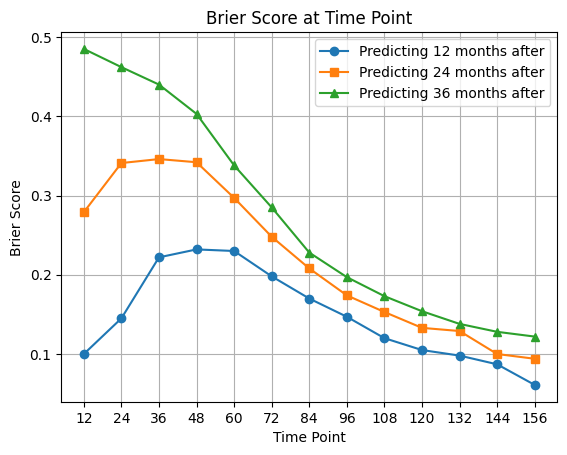

In [178]:
# Define X-axis break points
x_ticks = sorted(brier_df_12["Time point"].unique())  # Ensure breaks are correct

# Plot each dataframe as a separate line
plt.plot(brier_df_12["Time point"], brier_df_12["Brier Score"], marker='o', label="Predicting 12 months after")
plt.plot(brier_df_24["Time point"], brier_df_24["Brier Score"], marker='s', label="Predicting 24 months after")
plt.plot(brier_df_36["Time point"], brier_df_36["Brier Score"], marker='^', label="Predicting 36 months after")

# Labels and title
plt.xlabel("Time Point")
plt.ylabel("Brier Score")
plt.title("Brier Score at Time Point")
plt.legend()
plt.grid(True)

# Set x-axis breaks at 12, 24, 36, etc.
plt.xticks(x_ticks)

# Show the plot
plt.show()


## Recall score plot

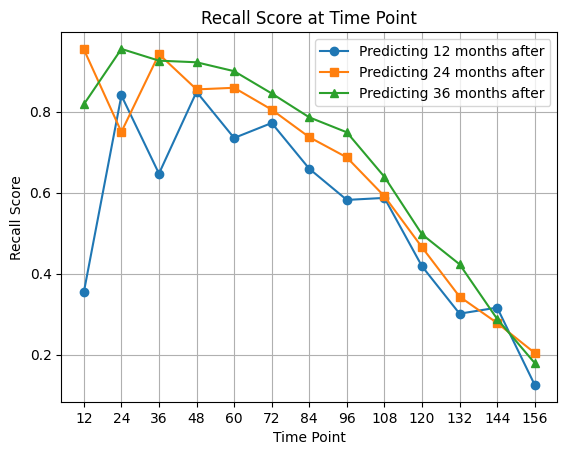

In [179]:
# Define X-axis break points
x_ticks = sorted(brier_df_12["Time point"].unique())  # Ensure breaks are correct

# Plot each dataframe as a separate line
plt.plot(brier_df_12["Time point"], brier_df_12["Recall"], marker='o', label="Predicting 12 months after")
plt.plot(brier_df_24["Time point"], brier_df_24["Recall"], marker='s', label="Predicting 24 months after")
plt.plot(brier_df_36["Time point"], brier_df_36["Recall"], marker='^', label="Predicting 36 months after")

# Labels and title
plt.xlabel("Time Point")
plt.ylabel("Recall Score")
plt.title("Recall Score at Time Point")
plt.legend()
plt.grid(True)

# Set x-axis breaks at 12, 24, 36, etc.
plt.xticks(x_ticks)

# Show the plot
plt.show()

## Accuracy score plot

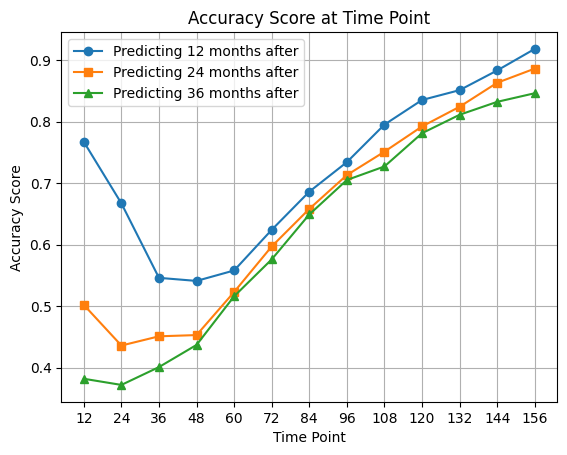

In [180]:
# Define X-axis break points
x_ticks = sorted(brier_df_12["Time point"].unique())  # Ensure breaks are correct

# Plot each dataframe as a separate line
plt.plot(brier_df_12["Time point"], brier_df_12["Accuracy"], marker='o', label="Predicting 12 months after")
plt.plot(brier_df_24["Time point"], brier_df_24["Accuracy"], marker='s', label="Predicting 24 months after")
plt.plot(brier_df_36["Time point"], brier_df_36["Accuracy"], marker='^', label="Predicting 36 months after")

# Labels and title
plt.xlabel("Time Point")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score at Time Point")
plt.legend()
plt.grid(True)

# Set x-axis breaks at 12, 24, 36, etc.
plt.xticks(x_ticks)

# Show the plot
plt.show()

# CUSTOMER INSTABILITY INDEX

In [181]:
active_customers = clean[clean["target_label"] == 0]

In [182]:
active_customers["last_x1/x1_mean"] = active_customers["last_x1"] / active_customers["x1_mean"]
active_customers["last_x2/x2_mean"] = active_customers["last_x2"] / active_customers["x2_mean"]



<positron-console-cell-182>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-182>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
pd.set_option('display.float_format', '{:.6f}'.format)

In [ ]:
customer_ages = active_customers["life"]

# Extract corresponding predictor features for the active customers
X_active = active_customers[important_features]  # Use the full feature set for all active customers

# Define prediction time offset for life + 12
time_offset = 12

# Compute future time for each customer
future_times = customer_ages + time_offset

# Predict survival function at these specific times for each customer
survival_probs_12 = np.array([
    aft_model.predict_survival_function(X_active.iloc[i:i+1], times=[future_times.iloc[i]]).values.flatten()[0]
    for i in range(len(X_active))
])

# Convert predictions to DataFrame
future_aft_df_12 = pd.DataFrame({"id": active_customers["id"], "life + 12": survival_probs_12})

# Set ID as index
future_aft_df_12 = future_aft_df_12.set_index("id")

In [ ]:
churn_aft_df_12 = 1 - future_aft_df_12

In [ ]:
risk_factors = active_customers[["id", "last_x1/x1_mean", "last_x2/x2_mean", "remain_contract_month", "avg_contract_length"]]

# Reset index for future survival probabilities
#churn_probs_12 = churn_aft_df_12.reset_index()
future_probs_12 = future_aft_df_12.reset_index()

# Merge survival probabilities with risk factors
risk_df_12 = future_probs_12.merge(risk_factors, on="id", how="outer")


# Normalize each feature to be within 0-1
risk_df_12["last_avg_contract_ratio"] = risk_df_12["last_avg_contract_ratio"] 
risk_df_12["last_x1/x1_mean"] = risk_df_12["last_x1/x1_mean"] / risk_df_12["last_x1/x1_mean"].max()
risk_df_12["last_x2/x2_mean"] = risk_df_12["last_x2/x2_mean"] / risk_df_12["last_x2/x2_mean"].max()
risk_df_12["remain_contract_month"] = risk_df_12["remain_contract_month"] / risk_df_12["remain_contract_month"].max()

# Compute risk score with normalized features
risk_df_12["risk_score"] = (
    risk_df_12["life + 12"] * 0.70 +  # Survival probability is already between 0-1
    risk_df_12["last_avg_contract_ratio"] * 0.15 +
    risk_df_12["last_x1/x1_mean"] * 0.05 +
    risk_df_12["last_x2/x2_mean"] * 0.05 +
    risk_df_12["remain_contract_month"] * 0.05
) * 100  # Scale to 100

# # Clip values to ensure risk score stays within 0-100
# risk_df_12["risk_score"] = risk_df_12["risk_score"].clip(0, 100)

# Keep only ID and risk score
risk_df_12 = risk_df_12[["id", "risk_score"]]

In [ ]:
customer_ages = active_customers["life"]

# Extract corresponding predictor features for the active customers
X_active = active_customers[important_features]  # Use the full feature set for all active customers

# Define prediction time offset for life + 24
time_offset = 24

# Compute future time for each customer
future_times = customer_ages + time_offset

# Predict survival function at these specific times for each customer
survival_probs_24 = np.array([
    aft_model.predict_survival_function(X_active.iloc[i:i+1], times=[future_times.iloc[i]]).values.flatten()[0]
    for i in range(len(X_active))
])

# Convert predictions to DataFrame
future_aft_df_24 = pd.DataFrame({"id": active_customers["id"], "life + 24": survival_probs_24})

# Set ID as index
future_aft_df_24 = future_aft_df_24.set_index("id")

In [ ]:
churn_aft_df_24 = 1 - future_aft_df_24

In [ ]:
risk_factors = active_customers[["id", "last_x1/x1_mean", "last_x2/x2_mean", "remain_contract_month", "avg_contract_length"]]

# Reset index for future survival probabilities
# churn_probs_24 = churn_aft_df_24.reset_index()
future_probs_24 = future_aft_df_24.reset_index()

# Merge survival probabilities with risk factors
risk_df_24 = future_probs_24.merge(risk_factors, on="id", how="outer")

# Normalize each feature to be within 0-1
risk_df_24["last_avg_contract_ratio"] = risk_df_24["last_avg_contract_ratio"] 
risk_df_24["last_x1/x1_mean"] = risk_df_24["last_x1/x1_mean"] / risk_df_24["last_x1/x1_mean"].max()
risk_df_24["last_x2/x2_mean"] = risk_df_24["last_x2/x2_mean"] / risk_df_24["last_x2/x2_mean"].max()
risk_df_24["remain_contract_month"] = risk_df_24["remain_contract_month"] / risk_df_24["remain_contract_month"].max()

# Compute risk score with normalized features
risk_df_24["risk_score"] = (
    risk_df_24["life + 24"] * 0.70 +  # Survival probability is already between 0-1
    risk_df_24["last_avg_contract_ratio"] * 0.15 +
    risk_df_24["last_x1/x1_mean"] * 0.05 +
    risk_df_24["last_x2/x2_mean"] * 0.05 +
    risk_df_24["remain_contract_month"] * 0.05
) * 100  # Scale to 100

# Keep only ID and risk score
risk_df_24 = risk_df_24[["id", "risk_score"]]

In [ ]:
risk_df_24_sorted = risk_df_24.sort_values(by="risk_score", ascending=False)
risk_df_24_sorted

### final approach using the 12 and 24 month weighted average

In [ ]:
# churn_probs_12 = churn_aft_df_12.reset_index()
# churn_probs_24 = churn_aft_df_24.reset_index()


# Merge churn probabilities for life + 12 and life + 24 with risk factors
risk_df_12_24 = future_probs_12.merge(future_probs_24, on="id", how="outer").merge(risk_factors, on="id", how="outer")

# Normalize each feature to be within 0-1
risk_df_12_24["last_avg_contract_ratio"] = risk_df_12_24["last_avg_contract_ratio"]
risk_df_12_24["last_x1/x1_mean"] = risk_df_12_24["last_x1/x1_mean"] / risk_df_12_24["last_x1/x1_mean"].max()
risk_df_12_24["last_x2/x2_mean"] = risk_df_12_24["last_x2/x2_mean"] / risk_df_12_24["last_x2/x2_mean"].max()
risk_df_12_24["remain_contract_month"] = risk_df_12_24["remain_contract_month"] / risk_df_12_24["remain_contract_month"].max()

# Compute updated risk score with new weightage
risk_df_12_24["risk_score"] = (
    risk_df_12_24["life + 12"] * 0.40 +  # Weight 40% for life + 12
    risk_df_12_24["life + 24"] * 0.30 +  # Weight 30% for life + 24
    risk_df_12_24["last_avg_contract_ratio"] * 0.15 +
    risk_df_12_24["last_x1/x1_mean"] * 0.05 +
    risk_df_12_24["last_x2/x2_mean"] * 0.05 +
    risk_df_12_24["remain_contract_month"] * 0.05
) * 1  # No additional scaling

# Keep only ID and risk score
risk_df_12_24 = risk_df_12_24[["id", "risk_score"]]

# Sort by highest risk score
risk_df_12_24_sorted = risk_df_12_24.sort_values(by="risk_score", ascending=False)

In [ ]:
risk_df_12_24["risk_score"] = pd.to_numeric(risk_df_12_24["risk_score"], errors="coerce")

# Create a new dataframe with 1 - risk_score
risk_df_inverse = risk_df_12_24.copy()
risk_df_inverse["inverse_risk_score"] = 1 - risk_df_inverse["risk_score"]

# Keep only ID and inverse risk score
risk_df_inverse = risk_df_inverse[["id", "inverse_risk_score"]]

In [ ]:
risk_df_inverse.sort_values(by="inverse_risk_score", ascending=False)

### CII per category combo

In [ ]:
clean['Category_Combo'] = clean['cat1'] + '-' + clean['cat2']

In [ ]:
risk_merged = risk_df_inverse.merge(clean[['id', 'Category_Combo']], on='id', how='left')

In [ ]:
risk_merged.to_csv('risk_merged.csv', index=False)